# Demonstration of RF-Garch 

In [1]:
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score,f1_score
import matplotlib.pyplot as plt
from arch import arch_model
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt import objective_functions
from pypfopt.black_litterman import BlackLittermanModel

# tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA', 'INTC', 'IBM', 'CSCO', 'ORCL', 'AMD', 'TXN', 'QCOM']



In [2]:
from datetime import datetime, timedelta
def date_forward_calculator(start_date, shift):

    # Calculate the end date by adding the rolling window size in days
    end_date_dt = start_date + timedelta(days=shift)


    end_date = end_date_dt.strftime('%Y-%m-%d')

    return end_date

# Function to fetch historical stock prices
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)[['Adj Close','Volume']]
    return stock_data


def calculate_ema(df, price_column, ema_column, alpha):
    df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
    return df

def calculate_sma(df, price_column, sma_column, window=20):
    df[sma_column] = df[price_column].rolling(window=window).mean()
    return df

def calculate_ema(df, price_column, ema_column, alpha=0.2):
    df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
    return df

def calculate_rsi(df, price_column, rsi_column, window=14):
    price_diff = df[price_column].diff(1)
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    df[rsi_column] = 100 - (100 / (1 + rs))
    return df

def calculate_macd(df, price_column, macd_column, signal_column, short_window=12, long_window=26, signal_window=9):
    short_ema = df[price_column].ewm(span=short_window, adjust=False).mean()
    long_ema = df[price_column].ewm(span=long_window, adjust=False).mean()
    
    df[macd_column] = short_ema - long_ema
    df[signal_column] = df[macd_column].ewm(span=signal_window, adjust=False).mean()
    
    return df

def calculate_bollinger_bands(df, price_column, bb_upper_column, bb_lower_column, window=20, num_std=2):
    rolling_mean = df[price_column].rolling(window=window).mean()
    rolling_std = df[price_column].rolling(window=window).std()
    
    df[bb_upper_column] = rolling_mean + (rolling_std * num_std)
    df[bb_lower_column] = rolling_mean - (rolling_std * num_std)
    
    return df
def calculate_top_k_percent(df, price_column, k):
    df['Top_K_Percent'] = df[price_column].pct_change().rolling(window=len(df), min_periods=1).sum().gt(k / 100).astype(int)
    return df

def calculate_obv(df, price_column, volume_column, obv_column='OBV'):
    df[obv_column] = (df[price_column].pct_change().shift(-1) > 0).astype(int) * df[volume_column]
    df[obv_column] = df[obv_column].cumsum()
    return df


# Assuming you have a DataFrame named df with 'Date' as the index
# Adjust the column names as needed

# Example usage:
# Assuming df is your DataFrame with 'Date' as the index and 'Stock_Price' as the stock price column
def get_tech_indicators(df,stock_name):
    df = calculate_ema(df, price_column=stock_name, ema_column=f"EMA_{stock_name}", alpha=0.2)
    stock_name = f"EMA_{stock_name}"
    df = calculate_sma(df, price_column=stock_name, sma_column='SMA_20', window=20)
    df = calculate_ema(df, price_column=stock_name, ema_column='EMA_12', alpha=0.2)
    df = calculate_rsi(df, price_column=stock_name, rsi_column='RSI_14')
    df = calculate_macd(df, price_column=stock_name, macd_column='MACD', signal_column='Signal', short_window=12, long_window=26, signal_window=9)
    df = calculate_bollinger_bands(df, price_column=stock_name, bb_upper_column='BB_Upper', bb_lower_column='BB_Lower', window=20, num_std=2)
    # Calculate Top K Percent (e.g., top 10%)
    # df = calculate_top_k_percent(df, stock_name, k=10)
    # Calculate On-Balance Volume (OBV)
    df = calculate_obv(df, stock_name, 'Volume')

    return df



def converter(dir):
    if dir:
        return 1
    else:
        return -1
        
def get_labelled_df(stock_data, m):
    df_overall = get_tech_indicators(stock_data, 'Adj Close')
    df_overall['Price_Direction'] = df_overall[ 'Adj Close'].shift(-m) > df_overall[ 'Adj Close']
    df_overall.dropna(inplace=True)
    df_overall['Price_Direction'] = df_overall['Price_Direction'].apply(lambda x: converter(x))
    # Drop rows with NaN in the label column
    df_overall = df_overall.reset_index()
    df_overall['forecast_date'] = df_overall['Date'].shift(-m)
    df_overall = df_overall.dropna()
    return df_overall

def get_actual_return(actual_price, last_price):
        return (actual_price - last_price)/last_price

In [44]:
tickers = ['AAPL','GOOGL','TSLA','JNJ']
start_date = '2020-01-01'
end_date = '2023-12-31'
step_size = 21
dict_ref = {}
dict_ref['stock'] = []
dict_ref['last_price'] = []
dict_ref['expected_price'] = []
dict_ref['expected_return'] = []
dict_ref['forecast_date'] = []
for stock in tickers:
    og_stock_data = fetch_stock_data(stock, start_date, end_date)
    # df_overall = get_labelled_df(og_stock_data, step_size)

    og_stock_data
    get_tech_indicators(og_stock_data, 'Adj Close')
    forecast_data = get_tech_indicators(og_stock_data, 'Adj Close').iloc[-1:]
    forecast_data
    df_overall = get_labelled_df(og_stock_data, step_size)
    df_overall
    train_data, test_data = train_test_split(df_overall, test_size=0.2)
    X_train, y_train = train_data.drop(['forecast_date','Date','Price_Direction'], axis=1), train_data['Price_Direction']
    X_test, y_test = test_data.drop(['forecast_date','Date','Price_Direction'], axis=1), test_data['Price_Direction']
    # Initialize and train RandomForestClassifier
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)
    # Predict on the test set
    predictions = rf_classifier.predict(X_test)
    # Assess accuracy
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    stock_pred_direction = rf_classifier.predict(forecast_data)
    stock_pred_direction
    selected_data = og_stock_data.iloc[::-step_size][::-1]
    selected_data
    returns = np.log(selected_data[ 'Adj Close'].shift(-1) / selected_data[ 'Adj Close']).dropna()
    returns
    garch_model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_result = garch_model.fit()

    # Forecast volatility for the next day
    forecasts = garch_result.forecast(horizon=1)
    forecasted_volatility = np.sqrt(forecasts.variance[-1:].values[0, 0])  # Sum over the forecast period

    # Modify based on your forecasting goals
    expected_return = returns.iloc[-1] + (forecasted_volatility * stock_pred_direction[0])
    expected_return

    # Calculate the expected price for the next day
    last_price = selected_data[ 'Adj Close'].iloc[-1]
    last_price
    expected_price = last_price * np.exp(expected_return)

    # Print the expected price
    print("Expected price 21 days from now:", expected_price)

    # expected_return = get_actual_return(expected_price, last_price)
    
    expected_return = get_actual_return(expected_price, last_price)
   

    forecast_date = date_forward_calculator(list(selected_data.reset_index()['Date'])[-1], 30)

    dict_ref['stock'] += [stock]
    dict_ref['last_price'] += [last_price]
    dict_ref['expected_price'] += [expected_price]
    dict_ref['expected_return'] += [expected_return]
    dict_ref['forecast_date'] += [forecast_date]


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 153124391.98935804
Iteration:      2,   Func. Count:     15,   Neg. LLF: 210148.03332933754
Iteration:      3,   Func. Count:     22,   Neg. LLF: -46.39157991166171
Iteration:      4,   Func. Count:     28,   Neg. LLF: -46.983059233761004
Iteration:      5,   Func. Count:     34,   Neg. LLF: -47.50409784191494
Iteration:      6,   Func. Count:     39,   Neg. LLF: -42.19089544772571
Iteration:      7,   Func. Count:     46,   Neg. LLF: -47.57326181108188
Iteration:      8,   Func. Count:     51,   Neg. LLF: -47.573373023901325
Iteration:      9,   Func. Count:     56,   Neg. LLF: -47.57338084177311
Iteration:     10,   Func. Count:     61,   Neg. LLF: 64.66783919144503
Optimization terminated successfully    (Exit mode 0)
            Current function value: -47.57338091463097
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 10
Expected price 21 days from now: 182.10452614438032


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 221488788.71027315
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2798712.554961022
Iteration:      3,   Func. Count:     21,   Neg. LLF: -41.16247827136081
Iteration:      4,   Func. Count:     27,   Neg. LLF: -49.38674445306204
Iteration:      5,   Func. Count:     32,   Neg. LLF: -49.41337431199813
Iteration:      6,   Func. Count:     37,   Neg. LLF: -49.417026424119555
Iteration:      7,   Func. Count:     42,   Neg. LLF: -49.41842767062995
Iteration:      8,   Func. Count:     47,   Neg. LLF: -49.41861736497392
Iteration:      9,   Func. Count:     52,   Neg. LLF: -49.418621551391126
Iteration:     10,   Func. Count:     56,   Neg. LLF: -49.41862155138012
Optimization terminated successfully    (Exit mode 0)
            Current function value: -49.418621551391126
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Expected price 21 days from now: 133.52939727180123


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3627323720.984396
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23039736.978904333
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7.024453245156484
Iteration:      4,   Func. Count:     28,   Neg. LLF: -3.5885266491077124
Iteration:      5,   Func. Count:     34,   Neg. LLF: -7.9336090038461355
Iteration:      6,   Func. Count:     39,   Neg. LLF: -7.933838444191153
Iteration:      7,   Func. Count:     44,   Neg. LLF: -7.933843330428163
Iteration:      8,   Func. Count:     48,   Neg. LLF: -7.933843330444834
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.933843330428163
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Expected price 21 days from now: 303.0854458537437


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_19091/4284502123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 385140775522.654
Iteration:      2,   Func. Count:     15,   Neg. LLF: 104.55160553005766
Iteration:      3,   Func. Count:     22,   Neg. LLF: -74.47506642400819
Iteration:      4,   Func. Count:     28,   Neg. LLF: -73.80060481949906
Iteration:      5,   Func. Count:     34,   Neg. LLF: -75.48006961233789
Iteration:      6,   Func. Count:     39,   Neg. LLF: -75.4804798678303
Iteration:      7,   Func. Count:     44,   Neg. LLF: -75.4800332218037
Iteration:      8,   Func. Count:     50,   Neg. LLF: 3589.09260632863
Optimization terminated successfully    (Exit mode 0)
            Current function value: -75.4806299819154
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 8
Expected price 21 days from now: 167.46531307832473


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002236. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [45]:
pd.DataFrame(dict_ref)

,stock,last_price,expected_price,expected_return,forecast_date
0,AAPL,192.284637,182.104526,-0.052943,2024-01-28
1,GOOGL,139.690002,133.529397,-0.044102,2024-01-28
2,TSLA,248.479996,303.085446,0.219758,2024-01-28
3,JNJ,155.558899,167.465313,0.076540,2024-01-28


In [47]:
risk_averse_level = 0.5
overall_exp_df = pd.DataFrame(dict_ref).dropna().set_index('stock')
mu = overall_exp_df['expected_return']
overall_stock_data = yf.download(list(pd.DataFrame(dict_ref)['stock']),start_date, end_date)['Adj Close']
cov_matrix = risk_models.CovarianceShrinkage(overall_stock_data).ledoit_wolf()
ef = EfficientFrontier(mu, cov_matrix)
returns = overall_stock_data.pct_change().dropna()
market_mu = returns.mean()

viewdict = pd.DataFrame(dict_ref)[['stock','expected_return']].set_index('stock').to_dict()['expected_return']
# Initialize the EfficientFrontier object with Black-Litterman model
bl_model = BlackLittermanModel(cov_matrix, pi=market_mu,  absolute_views=viewdict)

# Assuming P and Q vectors are defined somewhere

bl_equilibrium_returns = bl_model.bl_returns()

# Use the equilibrium returns in the EfficientFrontier optimization
ef.expected_returns = bl_equilibrium_returns

# Add constraints and maximize Sharpe ratio
ef.add_constraint(lambda w: w >= 0)
ef.add_constraint(lambda w: w <= 0.5)
# ef.efficient_risk(risk_averse_level)
ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
# ef.max_sharpe()
ef.efficient_risk(risk_averse_level)

# Get cleaned weights
cleaned_weights_bl = ef.clean_weights()


dict(cleaned_weights_bl)

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [9]:




def accuracy_rf(actual_return,expected_return):
    if (actual_return < 0 and expected_return < 0 ) or (actual_return > 0 and expected_return > 0 ):
        return True
    else:
        return False

def rf_and_garch(data_sofar, step_size = 21, forecast_horizon = 1, visualise_garch = False ):
    window_data = data_sofar.iloc[:-1]
    forecast_data = data_sofar.iloc[-1:]
    initial_date = forecast_data['Date'].iloc[0]
    forecast_date = forecast_data['forecast_date'].iloc[0]
    window_data = window_data[window_data['forecast_date']<initial_date]
    train_data, test_data = train_test_split(window_data, test_size=0.2)
    # Separate features and labels
    X_train, y_train = train_data.drop(['forecast_date','Date','Price_Direction'], axis=1), train_data['Price_Direction']
    X_test, y_test = test_data.drop(['forecast_date','Date','Price_Direction'], axis=1), test_data['Price_Direction']
    # Initialize and train RandomForestClassifier
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)
    # Predict on the test set
    predictions = rf_classifier.predict(X_test)
    # Assess accuracy
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    X_forecast, y_forecast = forecast_data.drop(['forecast_date','Date','Price_Direction'], axis=1), forecast_data['Price_Direction']
    stock_pred_direction = rf_classifier.predict(X_forecast)

    ## GARCH model
    selected_data = window_data.iloc[::-step_size][::-1]

    # Calculate log returns for selected data
    returns = np.log(selected_data[ 'Adj Close'].shift(-forecast_horizon) / selected_data[ 'Adj Close']).dropna()

    # Fit GARCH(1,1) model
    garch_model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_result = garch_model.fit()
    
    # Forecast volatility for the next day
    forecasts = garch_result.forecast(horizon=forecast_horizon)
    forecasted_volatility = np.sqrt(forecasts.variance[-1:].values[0, 0])  # Sum over the forecast period

    # Modify based on your forecasting goals
    expected_return = returns.iloc[-1] + (forecasted_volatility * stock_pred_direction[0])

    # Calculate the expected price for the next day
    last_price = window_data[ 'Adj Close'].iloc[-1]
    expected_price = last_price * np.exp(expected_return)
    
    # Print the expected price
    print("Expected price m days from now:", expected_price)
    
    expected_return = get_actual_return(expected_price, last_price)

    if visualise_garch:
        print(garch_result.summary())
        print("Forecasted volatility for the next day:", forecasts.variance[-1:].values[0, 0])

    
    return initial_date, forecast_date, last_price, expected_price, expected_return, \
         accuracy, recall, f1
       
    # , actual_price, expected_return, actual_return, accuracy
def get_cov_matrix(tickers,start_date,end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    cov_matrix = risk_models.sample_cov(stock_data)
    return cov_matrix

## Single Allocation 

In [10]:
def single_allocation_ml_approach(start_date,end_date,tickers,risk_averse_level=0.5):
    dict_exp_returns = {
        'stock': [],
        'date': [],
        'forecast_date': [],
        'last_price': [],
        'expected_price': [],
        'expected_return': [],}

    classification_performance = {
        'stock': [],
        'date': [],
        'forecast_date' : [],
        'accuracy': [],
        'recall': [],
        'f1_score': []}


    # @ 1 point in time
    for x in tickers:
        stock = x
        rolling_window_size = 3 * 252  # 16 years assuming 252 trading days per year
        step_size = 21 
        stock_data = fetch_stock_data(stock, start_date, end_date)
        df_overall = get_labelled_df(stock_data, step_size)
    
        print(df_overall.tail())

        initial_date, forecast_date, last_price, expected_price, expected_return,  accuracy, recall, f1 = rf_and_garch(df_overall)
        dict_exp_returns['stock'].append(stock)
        dict_exp_returns['date'].append(initial_date)
        dict_exp_returns['forecast_date'].append(forecast_date)
        dict_exp_returns['last_price'].append(last_price)
        dict_exp_returns['expected_price'].append(expected_price)
        dict_exp_returns['expected_return'].append(expected_return)

        classification_performance['stock'].append(stock)
        classification_performance['date'].append(initial_date)
        classification_performance['forecast_date'].append(forecast_date)
        classification_performance['accuracy'].append(accuracy)
        classification_performance['recall'].append(recall)
        classification_performance['f1_score'].append(f1)



    overall_exp_df = pd.DataFrame(dict_exp_returns).dropna().set_index('stock')
    mu = overall_exp_df['expected_return']
    overall_stock_data = yf.download(list(pd.DataFrame(dict_exp_returns)['stock']),start_date, initial_date)['Adj Close']
    cov_matrix = risk_models.CovarianceShrinkage(overall_stock_data).ledoit_wolf()
    ef = EfficientFrontier(mu, cov_matrix)
    returns = overall_stock_data.pct_change().dropna()
    market_mu = returns.mean()

    viewdict = pd.DataFrame(dict_exp_returns)[['stock','expected_return']].set_index('stock').to_dict()['expected_return']
    # Initialize the EfficientFrontier object with Black-Litterman model
    bl_model = BlackLittermanModel(cov_matrix, pi=market_mu,  absolute_views=viewdict)

    # Assuming P and Q vectors are defined somewhere

    bl_equilibrium_returns = bl_model.bl_returns()

    # Use the equilibrium returns in the EfficientFrontier optimization
    ef.expected_returns = bl_equilibrium_returns

    # Add constraints and maximize Sharpe ratio
    ef.add_constraint(lambda w: w >= 0)
    ef.add_constraint(lambda w: w <= 0.5)
    # ef.efficient_risk(risk_averse_level)
    ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
    # ef.max_sharpe()
    ef.efficient_risk(risk_averse_level)

    # Get cleaned weights
    cleaned_weights_bl = ef.clean_weights()


    # Display the results
    return dict(cleaned_weights_bl)

In [13]:
start_date = '2021-01-01'
end_date = '2023-12-31'
tickers = ['TSLA', 'NVDA', 'JPM' , 'WMT']
single_allocation_ml_approach(start_date,end_date,tickers)

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

          Date   Adj Close     Volume  EMA_Adj Close      SMA_20      EMA_12  \
708 2023-11-22  234.210007  117950600     232.668353  220.202787  227.165425   
709 2023-11-24  235.449997   65125200     233.224682  220.723530  228.377276   
710 2023-11-27  236.080002  112031800     233.795746  221.427924  229.460970   
711 2023-11-28  246.720001  148549900     236.380597  222.485039  230.844896   
712 2023-11-29  244.139999  135401300     237.932477  223.763731  232.262412   

        RSI_14      MACD    Signal    BB_Upper    BB_Lower          OBV  \
708  92.377973 -2.062436 -5.151684  234.101557  206.304017  39270636400   
709  92.066914 -1.349342 -4.391216  235.766869  205.680191  39335761600   
710  91.895990 -0.729719 -3.658916  237.551542  205.304306  39447793400   
711  92.295836 -0.029744 -2.933082  239.639345  205.330733  39596343300   
712  92.433024  0.642805 -2.217904  241.541078  205.986385  39731744600   

     Price_Direction forecast_date  
708                1    2023-12

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1922.1557758956342
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183.65150635852868
Iteration:      3,   Func. Count:     20,   Neg. LLF: 729.2757268954141
Iteration:      4,   Func. Count:     26,   Neg. LLF: -9.614512818832402
Iteration:      5,   Func. Count:     31,   Neg. LLF: -9.88187579164186
Iteration:      6,   Func. Count:     36,   Neg. LLF: -9.884473642439335
Iteration:      7,   Func. Count:     41,   Neg. LLF: -9.885033526994537
Iteration:      8,   Func. Count:     46,   Neg. LLF: -9.885045207953365
Iteration:      9,   Func. Count:     51,   Neg. LLF: -9.885048580165439
Iteration:     10,   Func. Count:     55,   Neg. LLF: -9.885048547616792
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.885048580165439
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10
Expected price m days from now: 211.49565739146448
          D

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 53.597128105570825
Iteration:      2,   Func. Count:     14,   Neg. LLF: 74.60242623712882
Iteration:      3,   Func. Count:     22,   Neg. LLF: -9.658319175238352
Iteration:      4,   Func. Count:     28,   Neg. LLF: -9.860299823053808
Iteration:      5,   Func. Count:     33,   Neg. LLF: -9.924872259379317
Iteration:      6,   Func. Count:     38,   Neg. LLF: -9.890422923712098
Iteration:      7,   Func. Count:     44,   Neg. LLF: -9.933994088788921
Iteration:      8,   Func. Count:     49,   Neg. LLF: -9.934900006962415
Iteration:      9,   Func. Count:     54,   Neg. LLF: -9.935143223754022
Iteration:     10,   Func. Count:     59,   Neg. LLF: -9.935149358168385
Iteration:     11,   Func. Count:     63,   Neg. LLF: -9.935149358150593
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.935149358168385
            Iterations: 11
            Function evaluations: 63
            Gradient eval

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004787. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=Fals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 158.8084687191097
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2756.058661158782
Iteration:      3,   Func. Count:     24,   Neg. LLF: -40.3337469112642
Iteration:      4,   Func. Count:     29,   Neg. LLF: -40.22815628584826
Iteration:      5,   Func. Count:     35,   Neg. LLF: -40.22532134938599
Iteration:      6,   Func. Count:     42,   Neg. LLF: -40.39973313041224
Iteration:      7,   Func. Count:     47,   Neg. LLF: -40.39997785494833
Iteration:      8,   Func. Count:     52,   Neg. LLF: -40.399985072021906
Iteration:      9,   Func. Count:     56,   Neg. LLF: -40.399985071898634
Optimization terminated successfully    (Exit mode 0)
            Current function value: -40.399985072021906
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Expected price m days from now: 115.61738655033066
          Date  Adj Close    Volume  EMA_Adj Close     SMA_20     EMA_12  \
708 2023

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 63195.78814935852
Iteration:      2,   Func. Count:     15,   Neg. LLF: -22.24738728434891
Iteration:      3,   Func. Count:     23,   Neg. LLF: -29.921095691035106
Iteration:      4,   Func. Count:     29,   Neg. LLF: 91.78989128480237
Iteration:      5,   Func. Count:     36,   Neg. LLF: -31.311208952229993
Iteration:      6,   Func. Count:     42,   Neg. LLF: -49.86932967245811
Iteration:      7,   Func. Count:     48,   Neg. LLF: -49.97571113850478
Iteration:      8,   Func. Count:     54,   Neg. LLF: -50.041782435965416
Iteration:      9,   Func. Count:     60,   Neg. LLF: -50.242799959551185
Iteration:     10,   Func. Count:     65,   Neg. LLF: -50.24476149232347
Iteration:     11,   Func. Count:     70,   Neg. LLF: -50.24611242819397
Iteration:     12,   Func. Count:     75,   Neg. LLF: -50.24618108425566
Iteration:     13,   Func. Count:     80,   Neg. LLF: -50.24618471258377
Iteration:     14,   Func. Count:     84,   Neg. 

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


{'TSLA': 0.16031, 'NVDA': 0.0, 'JPM': 0.33969, 'WMT': 0.5}

In [51]:
# start_date = '2021-01-01'
# end_date = '2023-12-31'
# tickers = ['TSLA', 'NVDA', 'JPM' , 'WMT']
# dict_exp_returns = {
#     'stock': [],
#     'date': [],
#     'forecast_date': [],
#     'last_price': [],
#     'expected_price': [],
#     'expected_return': [],}

# classification_performance = {
#     'stock': [],
#     'date': [],
#     'forecast_date' : [],
#     'accuracy': [],
#     'recall': [],
#     'f1_score': []}


# # @ 1 point in time
# for x in tickers:
#     stock = x
#     rolling_window_size = 3 * 252  # 16 years assuming 252 trading days per year
#     step_size = 21 
#     stock_data = fetch_stock_data(stock, start_date, end_date)
#     df_overall = get_labelled_df(stock_data, step_size)
 
#     print(df_overall.tail())

#     initial_date, forecast_date, last_price, expected_price, expected_return,  accuracy, recall, f1 = rf_and_garch(df_overall)
#     dict_exp_returns['stock'].append(stock)
#     dict_exp_returns['date'].append(initial_date)
#     dict_exp_returns['forecast_date'].append(forecast_date)
#     dict_exp_returns['last_price'].append(last_price)
#     dict_exp_returns['expected_price'].append(expected_price)
#     dict_exp_returns['expected_return'].append(expected_return)

#     classification_performance['stock'].append(stock)
#     classification_performance['date'].append(initial_date)
#     classification_performance['forecast_date'].append(forecast_date)
#     classification_performance['accuracy'].append(accuracy)
#     classification_performance['recall'].append(recall)
#     classification_performance['f1_score'].append(f1)



# overall_exp_df = pd.DataFrame(dict_exp_returns).dropna().set_index('stock')
# mu = overall_exp_df['expected_return']
# overall_stock_data = yf.download(list(pd.DataFrame(dict_exp_returns)['stock']),start_date, initial_date)['Adj Close']
# cov_matrix = risk_models.CovarianceShrinkage(overall_stock_data).ledoit_wolf()
# ef = EfficientFrontier(mu, cov_matrix)
# returns = overall_stock_data.pct_change().dropna()
# market_mu = returns.mean()

# viewdict = pd.DataFrame(dict_exp_returns)[['stock','expected_return']].set_index('stock').to_dict()['expected_return']
# # Initialize the EfficientFrontier object with Black-Litterman model
# bl_model = BlackLittermanModel(cov_matrix, pi=market_mu,  absolute_views=viewdict)

# # Assuming P and Q vectors are defined somewhere


# # Add constraints and maximize Sharpe ratio
# ef = EfficientFrontier(market_mu, cov_matrix)
# ef.add_constraint(lambda w: w <= 0.5)
# ef.add_constraint(lambda w: w >= 0)
# ef.efficient_risk(0.45)

# # Get cleaned weights
# cleaned_weights_bl = ef.clean_weights()

# # Display the results
# print("Optimal Weights:")
# print(cleaned_weights_bl)



In [52]:
# dict_exp_returns

In [53]:
# # Get expected return, volatility, and Sharpe ratio for the optimal portfolio
# expected_return, volatility, sharpe_ratio = ef.portfolio_performance()
# print("\nExpected Return:", expected_return)
# print("Volatility (Risk):", volatility)
# print("Sharpe Ratio:", sharpe_ratio)


# stock_data = yf.download(list(overall_exp_df.index), start='2023-11-30', end='2023-12-31')['Adj Close']
# returns = stock_data.pct_change().dropna()
# # Calculate portfolio returns
# portfolio_returns = returns.dot(list(cleaned_weights_bl.values()))

# # Calculate cumulative portfolio returns
# cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# # Plot cumulative portfolio returns
# cumulative_returns.plot(figsize=(10, 6), label='Portfolio')
# plt.title('Backtest Portfolio Performance')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Returns')
# plt.legend()
# plt.show()


## Continuous Allocation on monthly basis

In [14]:
import pandas as pd
from datetime import datetime
from datetime import datetime, timedelta

def date_forward_calculator(start_date, shift):
   
    # Calculate the end date by adding the rolling window size in days
    end_date_dt = start_date + timedelta(days=shift)

   
    end_date = end_date_dt.strftime('%Y-%m-%d')

    return end_date


# Specify the start date
start_date = '2022-01-01'  # Replace this with your desired start date

# Convert start_date to a datetime object
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = '2023-12-31'
end_date = datetime.strptime(end_date, '%Y-%m-%d') + pd.DateOffset(months=1)
# Get the first day of each month from start_date until today
first_day_of_month = pd.date_range(start=start_date, end=end_date, freq='MS')
last_day_of_month = pd.date_range(start=start_date, end=end_date, freq='M') + pd.offsets.MonthEnd(0)

print(len(first_day_of_month),len(last_day_of_month))


25 25


/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/3532621010.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last_day_of_month = pd.date_range(start=start_date, end=end_date, freq='M') + pd.offsets.MonthEnd(0)


In [15]:
first_day_of_month

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [16]:
last_day_of_month

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31'],
              dtype='datetime64[ns]', freq=None)

In [57]:
# # Backtest for monthly rebalancing/reconstituition


# rolling_window_size = 3 * 252  # 16 years assuming 252 trading days per year
# step_size = 21 

# dict_exp_returns = {
#     'stock': [],
#     'date': [],
#     'forecast_date': [],
#     'last_price': [],
#     'expected_price': [],
#     'expected_return': [],}

# classification_performance = {
#     'stock': [],
#     'date': [],
#     'forecast_date' : [],
#     'accuracy': [],
#     'recall': [],
#     'f1_score': []}


# portfolio_performance = {
#     'end_date':[],
#     'forecast_date':[],
#     'cleaned_weights':[],

# }


# start_date = '2021-01-01'  # Replace this with your desired start date
# end_date = '2023-12-31'
# # end_date = pd.to_datetime('today')
# # Convert start_date to a datetime object
# start_date = datetime.strptime(start_date, '%Y-%m-%d')
# # Get the first day of each month from start_date until today
# first_day_of_month = pd.date_range(start=start_date, end=end_date, freq='MS')
# portfolio_value = 100000
# for x in first_day_of_month:
#     start_date, end_date = date_forward_calculator(x, -rolling_window_size),x.date()
#     print(start_date,end_date)
    
#     for stock in tickers:
#         stock_data = fetch_stock_data(stock, start_date, end_date)
#         df_overall = get_labelled_df(stock_data, step_size)
#         if len(stock_data)<5:
#             continue
#         initial_date, forecast_date, last_price, expected_price, expected_return,  accuracy, recall, f1 = rf_and_garch(df_overall)
#         dict_exp_returns['stock'].append(stock)
#         dict_exp_returns['date'].append(initial_date)
#         dict_exp_returns['forecast_date'].append(forecast_date)
#         dict_exp_returns['last_price'].append(last_price)
#         dict_exp_returns['expected_price'].append(expected_price)
#         dict_exp_returns['expected_return'].append(expected_return)

#         classification_performance['stock'].append(stock)
#         classification_performance['date'].append(initial_date)
#         classification_performance['forecast_date'].append(forecast_date)
#         classification_performance['accuracy'].append(accuracy)
#         classification_performance['recall'].append(recall)
#         classification_performance['f1_score'].append(f1)
    
#     # Initialize the EfficientFrontier object
#     mu_df = pd.DataFrame(dict_exp_returns).set_index('stock')
#     mu_df = mu_df[mu_df['forecast_date']==forecast_date]

#     ## overall stock_data
#     overall_stock_data = yf.download(list(mu_df.index),start_date, initial_date)['Adj Close']
#     cov_matrix = risk_models.CovarianceShrinkage(overall_stock_data).ledoit_wolf()
#     mu = mu_df['expected_return']
#     ef = EfficientFrontier(mu, cov_matrix)
#     try:
#         ef.add_constraint(lambda w: w<=0.5)
#         ef.add_constraint(lambda w: w>=0)
#         ef.max_sharpe() 
#     except:
#         ef = EfficientFrontier(mu, cov_matrix)
#         ef.add_constraint(lambda w: w<=0.5)
#         ef.add_constraint(lambda w: w>=0)
#         ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
#         ef.efficient_risk(0.45)
#     weights = ef.clean_weights()
#     cleaned_weights = ef.clean_weights()

#     portfolio_performance['end_date'].append(initial_date)
#     portfolio_performance['forecast_date'].append(forecast_date)
#     portfolio_performance['cleaned_weights'].append(cleaned_weights)




In [58]:
# pd.DataFrame(dict_exp_returns).to_csv('expected_returns_portfolio.csv')

In [59]:
# pd.DataFrame(portfolio_performance)

In [17]:
# Backtest for monthly rebalancing/reconstituition
#ORIGINAL
from pypfopt.black_litterman import BlackLittermanModel

rolling_window_size = 3 * 252  # 16 years assuming 252 trading days per year
step_size = 21 

dict_exp_returns = {
    'stock': [],
    'date': [],
    'forecast_date': [],
    'last_price': [],
    'expected_price': [],
    'expected_return': [],}

classification_performance = {
    'stock': [],
    'date': [],
    'forecast_date' : [],
    'accuracy': [],
    'recall': [],
    'f1_score': []}
    
portfolio_performance = {
    'end_date':[],
    'forecast_date':[],
    'cleaned_weights':[],

}

portfolio_performance_bl = {
    'end_date':[],
    'forecast_date':[],
    'cleaned_weights':[],

}


start_date = '2022-01-01'  # Replace this with your desired start date
end_date = '2024-01-15'
# end_date = pd.to_datetime('today')
# Convert start_date to a datetime object
start_date = datetime.strptime(start_date, '%Y-%m-%d')
# Get the first day of each month from start_date until today
first_day_of_month = pd.date_range(start=start_date, end=end_date, freq='MS')
last_day_of_month = pd.date_range(start=start_date, end=end_date, freq='M') + pd.offsets.MonthEnd(0)
portfolio_value = 100000
risk_averse_level = 0.5
# for x in range(1,len(first_day_of_month)):
#     start_date, end_date = date_forward_calculator(first_day_of_month[x], -rolling_window_size),first_day_of_month[x]
#     initial_date = first_day_of_month[x-1]
#     forecast_date = end_date
for x in range(len(first_day_of_month)):
    reference_date = first_day_of_month[x]
    start_date_of_data, initial_date = date_forward_calculator(reference_date, -rolling_window_size),reference_date
    last_date_of_train_data = reference_date - pd.DateOffset(days=1)
    forecast_date =  last_day_of_month[x]
    for stock in tickers:
        stock_data = fetch_stock_data(stock, start_date_of_data, reference_date)
        df_overall = get_labelled_df(stock_data, step_size)
        if len(stock_data)<5:
            continue
        blank1, blank, last_price, expected_price, expected_return,  accuracy, recall, f1 = rf_and_garch(df_overall)
        dict_exp_returns['stock'].append(stock)
        dict_exp_returns['date'].append(initial_date)
        dict_exp_returns['forecast_date'].append(forecast_date)
        dict_exp_returns['last_price'].append(last_price)
        dict_exp_returns['expected_price'].append(expected_price)
        dict_exp_returns['expected_return'].append(expected_return)

        classification_performance['stock'].append(stock)
        classification_performance['date'].append(initial_date)
        classification_performance['forecast_date'].append(forecast_date)
        classification_performance['accuracy'].append(accuracy)
        classification_performance['recall'].append(recall)
        classification_performance['f1_score'].append(f1)
    
    # Initialize the EfficientFrontier object
    mu_df = pd.DataFrame(dict_exp_returns).set_index('stock')
    mu_df = mu_df[mu_df['forecast_date']==forecast_date]

    ## overall stock_data
    overall_stock_data = yf.download(list(pd.DataFrame(dict_exp_returns)['stock']),start_date_of_data, reference_date)['Adj Close']
    cov_matrix = risk_models.CovarianceShrinkage(overall_stock_data).ledoit_wolf()
    mu = mu_df['expected_return']
    ef = EfficientFrontier(mu, cov_matrix)
    try:
        ef.add_constraint(lambda w: w<=0.5)
        ef.add_constraint(lambda w: w>=0)
        ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
        ef.efficient_risk(0.45)
    except:
        ef = EfficientFrontier(mu, cov_matrix)
        ef.add_constraint(lambda w: w<=0.5)
        ef.add_constraint(lambda w: w>=0)
        ef.max_sharpe()
    weights = ef.clean_weights()
    cleaned_weights = ef.clean_weights()

    portfolio_performance['end_date'].append(initial_date)
    portfolio_performance['forecast_date'].append(forecast_date)
    portfolio_performance['cleaned_weights'].append(cleaned_weights)
   
    # Calculate market returns
    returns = overall_stock_data.pct_change().dropna()
    market_mu = returns.mean()

    viewdict = pd.DataFrame(dict_exp_returns)[['stock','expected_return']].set_index('stock').to_dict()['expected_return']
    # Initialize the EfficientFrontier object with Black-Litterman model
    bl_model = BlackLittermanModel(cov_matrix, pi=market_mu,  absolute_views=viewdict)

    # Assuming P and Q vectors are defined somewhere
   
    bl_equilibrium_returns = bl_model.bl_returns()

#     # Now, you can use the bl_equilibrium_returns in your portfolio optimization
    ef_bl = EfficientFrontier(bl_equilibrium_returns, cov_matrix)
    try:
    # Add constraints and maximize Sharpe ratio (modify as per your requirements)
        ef_bl.add_constraint(lambda w: w >= 0)
        ef_bl.add_constraint(lambda w: w <= 0.5)
        ef_bl.add_objective(objective_functions.L2_reg, gamma=0.1)
        ef_bl.efficient_risk(risk_averse_level)
    except:
        ef_bl.add_constraint(lambda w: w<=0.5)
        ef_bl.add_constraint(lambda w: w>=0)
        ef_bl.max_sharpe()
    cleaned_weights_bl = ef_bl.clean_weights()


    # Update portfolio_performance_bl dictionary
    portfolio_performance_bl['end_date'].append(initial_date)
    portfolio_performance_bl['forecast_date'].append(forecast_date)
    portfolio_performance_bl['cleaned_weights'].append(cleaned_weights_bl)



/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/2877318899.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last_day_of_month = pd.date_range(start=start_date, end=end_date, freq='M') + pd.offsets.MonthEnd(0)
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Iteration:      1,   Func. Count:      6,   Neg. LLF: 114895190.38366893
Iteration:      2,   Func. Count:     13,   Neg. LLF: 208862503.88545322
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1.5158678864514337
Iteration:      4,   Func. Count:     26,   Neg. LLF: -2.199187244396852
Iteration:      5,   Func. Count:     32,   Neg. LLF: -2.5097209264031797
Iteration:      6,   Func. Count:     37,   Neg. LLF: -2.612033125316023
Iteration:      7,   Func. Count:     42,   Neg. LLF: -2.421018973573205
Iteration:      8,   Func. Count:     48,   Neg. LLF: -2.650815440586153
Iteration:      9,   Func. Count:     53,   Neg. LLF: -2.6508368739151176
Iteration:     10,   Func. Count:     57,   Neg. LLF: -2.650836873959534
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.6508368739151176
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Expected price m days from now: 457.33655523470077


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 426741240.78685635
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12895844.976076003
Iteration:      3,   Func. Count:     21,   Neg. LLF: -19.217154530410973
Iteration:      4,   Func. Count:     27,   Neg. LLF: -19.262184325295582
Iteration:      5,   Func. Count:     33,   Neg. LLF: -19.400639308934238
Iteration:      6,   Func. Count:     38,   Neg. LLF: -19.40965128663689
Iteration:      7,   Func. Count:     43,   Neg. LLF: -19.40769911039878
Iteration:      8,   Func. Count:     49,   Neg. LLF: -19.410335635250608
Iteration:      9,   Func. Count:     54,   Neg. LLF: -19.410500155147627
Iteration:     10,   Func. Count:     59,   Neg. LLF: -19.410520132250564
Iteration:     11,   Func. Count:     64,   Neg. LLF: -19.41052145688151
Iteration:     12,   Func. Count:     68,   Neg. LLF: -19.410521456862845
Optimization terminated successfully    (Exit mode 0)
            Current function value: -19.41052145688151
        

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3777781162.0673513
Iteration:      2,   Func. Count:     15,   Neg. LLF: 13006034.973560248
Iteration:      3,   Func. Count:     21,   Neg. LLF: -15.755908358033492
Iteration:      4,   Func. Count:     27,   Neg. LLF: -21.193612006616746
Iteration:      5,   Func. Count:     32,   Neg. LLF: -17.318685265768828
Iteration:      6,   Func. Count:     38,   Neg. LLF: -21.47568171527338
Iteration:      7,   Func. Count:     43,   Neg. LLF: 46376325.905187294
Iteration:      8,   Func. Count:     52,   Neg. LLF: 10178915.989367872
Iteration:      9,   Func. Count:     60,   Neg. LLF: -21.47889734597396
Iteration:     10,   Func. Count:     65,   Neg. LLF: -21.47939472090267
Iteration:     11,   Func. Count:     70,   Neg. LLF: -18.224458304032716
Optimization terminated successfully    (Exit mode 0)
            Current function value: -21.479395271386707
            Iterations: 13
            Function evaluations: 74
            Gradien

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 323.3126505809781
Iteration:      2,   Func. Count:     15,   Neg. LLF: -4.124997780659995
Iteration:      3,   Func. Count:     23,   Neg. LLF: -33.2167632270323
Iteration:      4,   Func. Count:     29,   Neg. LLF: -33.28984190940612
Iteration:      5,   Func. Count:     34,   Neg. LLF: -33.29297501607897
Iteration:      6,   Func. Count:     39,   Neg. LLF: -33.29317831552448
Iteration:      7,   Func. Count:     44,   Neg. LLF: -33.29335931950531
Iteration:      8,   Func. Count:     49,   Neg. LLF: -33.29338061427383
Iteration:      9,   Func. Count:     54,   Neg. LLF: -33.29339122691176
Iteration:     10,   Func. Count:     59,   Neg. LLF: -33.29339736877773
Iteration:     11,   Func. Count:     64,   Neg. LLF: -33.29339941634051
Iteration:     12,   Func. Count:     68,   Neg. LLF: -33.29339941434618
Optimization terminated successfully    (Exit mode 0)
            Current function value: -33.29339941634051
            Itera

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6637837212.049628
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8253958.011382885
Iteration:      3,   Func. Count:     20,   Neg. LLF: -5.187420092990792
Iteration:      4,   Func. Count:     28,   Neg. LLF: -6.198293315375891
Iteration:      5,   Func. Count:     34,   Neg. LLF: -6.786161874152532
Iteration:      6,   Func. Count:     39,   Neg. LLF: -6.766369838765125
Iteration:      7,   Func. Count:     45,   Neg. LLF: -6.8475538022520706
Iteration:      8,   Func. Count:     50,   Neg. LLF: -6.847632884926854
Iteration:      9,   Func. Count:     54,   Neg. LLF: -6.847632884825626
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.847632884926854
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Expected price m days from now: 356.88940984689896


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01044. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3864.305146164201
Iteration:      2,   Func. Count:     15,   Neg. LLF: 17.191102169944067
Iteration:      3,   Func. Count:     23,   Neg. LLF: -18.231277990887815
Iteration:      4,   Func. Count:     29,   Neg. LLF: -18.42261905044533
Iteration:      5,   Func. Count:     35,   Neg. LLF: -18.456642244984998
Iteration:      6,   Func. Count:     41,   Neg. LLF: -18.46545511244402
Iteration:      7,   Func. Count:     46,   Neg. LLF: -18.465584825035215
Iteration:      8,   Func. Count:     51,   Neg. LLF: -18.465607802551858
Iteration:      9,   Func. Count:     56,   Neg. LLF: -18.46560910195786
Iteration:     10,   Func. Count:     60,   Neg. LLF: -18.46560910195531
Optimization terminated successfully    (Exit mode 0)
            Current function value: -18.46560910195786
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Expected price m days from now: 517.8132104360759



/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value i

Iteration:      1,   Func. Count:      6,   Neg. LLF: 28079670465.606346
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8288118.188682437
Iteration:      3,   Func. Count:     20,   Neg. LLF: 59.9642982907375
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5.923548014652123
Iteration:      5,   Func. Count:     32,   Neg. LLF: -6.56182600483406
Iteration:      6,   Func. Count:     38,   Neg. LLF: -10.812546032696488
Iteration:      7,   Func. Count:     44,   Neg. LLF: -12.375620520735051
Iteration:      8,   Func. Count:     50,   Neg. LLF: -17.03204465894911
Iteration:      9,   Func. Count:     56,   Neg. LLF: -18.752056420915707
Iteration:     10,   Func. Count:     62,   Neg. LLF: -19.495529505938194
Iteration:     11,   Func. Count:     68,   Neg. LLF: -19.88701242976096
Iteration:     12,   Func. Count:     74,   Neg. LLF: -20.363551161467168
Iteration:     13,   Func. Count:     80,   Neg. LLF: -20.666104243374544
Iteration:     14,   Func. Count:     86,   Neg. L

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: -6.937972612302752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1147.3161567215939
Iteration:      3,   Func. Count:     23,   Neg. LLF: -34.672215625972825
Iteration:      4,   Func. Count:     28,   Neg. LLF: -34.68077321542507
Iteration:      5,   Func. Count:     33,   Neg. LLF: -34.69607279854396
Iteration:      6,   Func. Count:     38,   Neg. LLF: -34.69640903648401
Iteration:      7,   Func. Count:     43,   Neg. LLF: -34.69657628144843
Iteration:      8,   Func. Count:     48,   Neg. LLF: -34.69664482380908
Iteration:      9,   Func. Count:     53,   Neg. LLF: -34.69664932731644
Iteration:     10,   Func. Count:     57,   Neg. LLF: -34.69664932561729
Optimization terminated successfully    (Exit mode 0)
            Current function value: -34.69664932731644
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Expected price m days from now: 41.95357302574292


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1483748530.560799
Iteration:      2,   Func. Count:     14,   Neg. LLF: 11209768.646060867
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7.265884154106675
Iteration:      4,   Func. Count:     26,   Neg. LLF: -7.469803294330834
Iteration:      5,   Func. Count:     31,   Neg. LLF: -7.5105321251176616
Iteration:      6,   Func. Count:     36,   Neg. LLF: -7.512131746715898
Iteration:      7,   Func. Count:     41,   Neg. LLF: -7.512152647101034
Iteration:      8,   Func. Count:     46,   Neg. LLF: -7.5121550890817215
Iteration:      9,   Func. Count:     50,   Neg. LLF: -7.512155089070574
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.5121550890817215
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9
Expected price m days from now: 405.52330655519006


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 127.7894227111876
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1999.8005330236497
Iteration:      3,   Func. Count:     24,   Neg. LLF: -19.174738173040293
Iteration:      4,   Func. Count:     29,   Neg. LLF: -17.94671291393167
Iteration:      5,   Func. Count:     35,   Neg. LLF: -19.197436571248254
Iteration:      6,   Func. Count:     40,   Neg. LLF: -19.19750748921502
Iteration:      7,   Func. Count:     45,   Neg. LLF: -19.19750796605988
Optimization terminated successfully    (Exit mode 0)
            Current function value: -19.19750796605988
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Expected price m days from now: 260.89155693680243


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35.790389902717024
Iteration:      2,   Func. Count:     14,   Neg. LLF: 94.77696857549633
Iteration:      3,   Func. Count:     22,   Neg. LLF: -27.484786037976463
Iteration:      4,   Func. Count:     27,   Neg. LLF: -27.485582015677817
Iteration:      5,   Func. Count:     32,   Neg. LLF: -27.485826393727343
Iteration:      6,   Func. Count:     37,   Neg. LLF: -27.48591852065438
Iteration:      7,   Func. Count:     42,   Neg. LLF: -27.48592285612407
Iteration:      8,   Func. Count:     46,   Neg. LLF: -27.48592285587425
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.48592285612407
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
Expected price m days from now: 149.63913860179207


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 108457636075.35214
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8522210.76762168
Iteration:      3,   Func. Count:     21,   Neg. LLF: -25.02105677748381
Iteration:      4,   Func. Count:     27,   Neg. LLF: -28.548667633105904
Iteration:      5,   Func. Count:     33,   Neg. LLF: -19.751617023891548
Iteration:      6,   Func. Count:     40,   Neg. LLF: -30.019694972344386
Iteration:      7,   Func. Count:     46,   Neg. LLF: -30.08376798399287
Iteration:      8,   Func. Count:     52,   Neg. LLF: -30.31900780027548
Iteration:      9,   Func. Count:     58,   Neg. LLF: -30.35763628312727
Iteration:     10,   Func. Count:     64,   Neg. LLF: -30.816517346432278
Iteration:     11,   Func. Count:     70,   Neg. LLF: -31.228339059218776
Iteration:     12,   Func. Count:     76,   Neg. LLF: -31.509035240058186
Iteration:     13,   Func. Count:     82,   Neg. LLF: -26.12144793045382
Iteration:     14,   Func. Count:     88,   Neg

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 25.28169324046268
Iteration:      2,   Func. Count:     14,   Neg. LLF: -5.045213380694799
Iteration:      3,   Func. Count:     22,   Neg. LLF: -7.6827735625891105
Iteration:      4,   Func. Count:     27,   Neg. LLF: -7.682780656599176
Iteration:      5,   Func. Count:     32,   Neg. LLF: -7.682781972565428
Iteration:      6,   Func. Count:     37,   Neg. LLF: -7.682797589847507
Iteration:      7,   Func. Count:     42,   Neg. LLF: -7.683554733888476
Iteration:      8,   Func. Count:     47,   Neg. LLF: -7.684375955848914
Iteration:      9,   Func. Count:     52,   Neg. LLF: -7.672573783128028
Iteration:     10,   Func. Count:     59,   Neg. LLF: -7.552247251577024
Iteration:     11,   Func. Count:     65,   Neg. LLF: -7.697962180372887
Iteration:     12,   Func. Count:     70,   Neg. LLF: -7.69853427313766
Iteration:     13,   Func. Count:     75,   Neg. LLF: -7.698640117770445
Iteration:     14,   Func. Count:     80,   Neg. LLF

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 387.76414239431443
Iteration:      2,   Func. Count:     15,   Neg. LLF: 31.64090774744713
Iteration:      3,   Func. Count:     24,   Neg. LLF: -9.5821708815582
Iteration:      4,   Func. Count:     30,   Neg. LLF: -15.714294918365075
Iteration:      5,   Func. Count:     35,   Neg. LLF: -15.677311293280972
Iteration:      6,   Func. Count:     41,   Neg. LLF: -15.729537623450232
Iteration:      7,   Func. Count:     46,   Neg. LLF: -15.730441786734511
Iteration:      8,   Func. Count:     51,   Neg. LLF: -15.7304525072202
Iteration:      9,   Func. Count:     55,   Neg. LLF: -15.73045251319907
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.7304525072202
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Expected price m days from now: 225.04060237214938


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13.208617984469258
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1986.0141247845067
Iteration:      3,   Func. Count:     23,   Neg. LLF: -25.75692300009267
Iteration:      4,   Func. Count:     28,   Neg. LLF: -25.759582514603892
Iteration:      5,   Func. Count:     33,   Neg. LLF: -25.75962119334411
Iteration:      6,   Func. Count:     38,   Neg. LLF: -25.759655456739704
Iteration:      7,   Func. Count:     43,   Neg. LLF: -25.759665161410975
Iteration:      8,   Func. Count:     48,   Neg. LLF: -25.759674050467503
Iteration:      9,   Func. Count:     52,   Neg. LLF: -25.759674050176002
Optimization terminated successfully    (Exit mode 0)
            Current function value: -25.759674050467503
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Expected price m days from now: 137.79094874851563


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7303858.618133466
Iteration:      2,   Func. Count:     15,   Neg. LLF: 10470547.218553118
Iteration:      3,   Func. Count:     22,   Neg. LLF: -35.176103010550015
Iteration:      4,   Func. Count:     28,   Neg. LLF: -35.248357460093736
Iteration:      5,   Func. Count:     33,   Neg. LLF: -35.29509145052536
Iteration:      6,   Func. Count:     38,   Neg. LLF: -35.29528201752597
Iteration:      7,   Func. Count:     43,   Neg. LLF: -35.2952858207929
Iteration:      8,   Func. Count:     47,   Neg. LLF: -35.29528582082634
Optimization terminated successfully    (Exit mode 0)
            Current function value: -35.2952858207929
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Expected price m days from now: 44.38672181311538


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1275894242.1957645
Iteration:      2,   Func. Count:     14,   Neg. LLF: 9916468.367312834
Iteration:      3,   Func. Count:     21,   Neg. LLF: -4.792690785165966
Iteration:      4,   Func. Count:     27,   Neg. LLF: -4.9668030262674625
Iteration:      5,   Func. Count:     33,   Neg. LLF: -5.025978248804696
Iteration:      6,   Func. Count:     39,   Neg. LLF: -5.179607546845181
Iteration:      7,   Func. Count:     45,   Neg. LLF: -7.112041404601852
Iteration:      8,   Func. Count:     51,   Neg. LLF: -6.734620840912622
Iteration:      9,   Func. Count:     57,   Neg. LLF: -7.41085419384967
Iteration:     10,   Func. Count:     63,   Neg. LLF: -7.4682961228710845
Iteration:     11,   Func. Count:     68,   Neg. LLF: -7.3573218128433515
Iteration:     12,   Func. Count:     74,   Neg. LLF: -7.479776882511835
Iteration:     13,   Func. Count:     79,   Neg. LLF: -7.479791991544047
Iteration:     14,   Func. Count:     84,   Neg. L

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01575. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 80.71129270256063
Iteration:      2,   Func. Count:     15,   Neg. LLF: 94.93290204098008
Iteration:      3,   Func. Count:     24,   Neg. LLF: -14.055512515983127
Iteration:      4,   Func. Count:     30,   Neg. LLF: -15.01817105372316
Iteration:      5,   Func. Count:     35,   Neg. LLF: -15.029504178267668
Iteration:      6,   Func. Count:     40,   Neg. LLF: -15.029584744123524
Iteration:      7,   Func. Count:     45,   Neg. LLF: -15.029658081101772
Iteration:      8,   Func. Count:     49,   Neg. LLF: -15.029658120813766
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.029658081101772
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 221.16837363584168



/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value i

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1856420776.659069
Iteration:      2,   Func. Count:     14,   Neg. LLF: 299811.5802485239
Iteration:      3,   Func. Count:     21,   Neg. LLF: -27.105931795056684
Iteration:      4,   Func. Count:     26,   Neg. LLF: -27.15691513658468
Iteration:      5,   Func. Count:     32,   Neg. LLF: -27.2408148476409
Iteration:      6,   Func. Count:     37,   Neg. LLF: -27.251265965759245
Iteration:      7,   Func. Count:     42,   Neg. LLF: -27.252469203510003
Iteration:      8,   Func. Count:     47,   Neg. LLF: -27.252469832530437
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.252469832530437
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Expected price m days from now: 123.17530968672366


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8155037.661609981
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11515413.067581724
Iteration:      3,   Func. Count:     22,   Neg. LLF: -35.967356335988285
Iteration:      4,   Func. Count:     28,   Neg. LLF: -36.17031235355095
Iteration:      5,   Func. Count:     33,   Neg. LLF: -36.27138881716715
Iteration:      6,   Func. Count:     38,   Neg. LLF: -36.26624255534572
Iteration:      7,   Func. Count:     44,   Neg. LLF: -36.27417370424245
Iteration:      8,   Func. Count:     48,   Neg. LLF: -36.274173704823596
Optimization terminated successfully    (Exit mode 0)
            Current function value: -36.27417370424245
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Expected price m days from now: 41.86375287064143


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1625464211.2806203
Iteration:      2,   Func. Count:     14,   Neg. LLF: 9568110.630621105
Iteration:      3,   Func. Count:     21,   Neg. LLF: -0.893135055331896
Iteration:      4,   Func. Count:     27,   Neg. LLF: -5.124713228356079
Iteration:      5,   Func. Count:     33,   Neg. LLF: -6.308495274023298
Iteration:      6,   Func. Count:     39,   Neg. LLF: -6.899228593590689
Iteration:      7,   Func. Count:     45,   Neg. LLF: -7.208526360924576
Iteration:      8,   Func. Count:     51,   Neg. LLF: -7.413720908098979
Iteration:      9,   Func. Count:     56,   Neg. LLF: -7.414107782244553
Iteration:     10,   Func. Count:     62,   Neg. LLF: -7.421231852953945
Iteration:     11,   Func. Count:     67,   Neg. LLF: -7.4228481921138165
Iteration:     12,   Func. Count:     72,   Neg. LLF: -7.422860037298461
Iteration:     13,   Func. Count:     76,   Neg. LLF: -7.4228600374539235
Optimization terminated successfully    (Exit mode

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01632. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 23.22550439885287
Iteration:      2,   Func. Count:     16,   Neg. LLF: 122.81736133741737
Iteration:      3,   Func. Count:     24,   Neg. LLF: -14.183323460949206
Iteration:      4,   Func. Count:     29,   Neg. LLF: 634.3375082353779
Iteration:      5,   Func. Count:     35,   Neg. LLF: -14.334212506709228
Iteration:      6,   Func. Count:     40,   Neg. LLF: -14.334784058322832
Iteration:      7,   Func. Count:     45,   Neg. LLF: -14.33478624247034
Iteration:      8,   Func. Count:     49,   Neg. LLF: -14.334786181674518
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14.33478624247034
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 392.5400099961363


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 79017167.37679489
Iteration:      2,   Func. Count:     15,   Neg. LLF: 102101.77472395168
Iteration:      3,   Func. Count:     22,   Neg. LLF: -27.568824055955908
Iteration:      4,   Func. Count:     27,   Neg. LLF: -27.677658926460055
Iteration:      5,   Func. Count:     33,   Neg. LLF: -27.833752243332796
Iteration:      6,   Func. Count:     38,   Neg. LLF: -27.84401005530056
Iteration:      7,   Func. Count:     43,   Neg. LLF: -27.846043738802287
Iteration:      8,   Func. Count:     48,   Neg. LLF: -27.84611858757785
Iteration:      9,   Func. Count:     53,   Neg. LLF: -27.84620445885051
Iteration:     10,   Func. Count:     58,   Neg. LLF: -24.022369429108625
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.846204576301098
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 10
Expected price m days from now: 125.67835803386974



/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value i

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2927351596.3526807
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8431478.971175265
Iteration:      3,   Func. Count:     22,   Neg. LLF: -33.603681103214065
Iteration:      4,   Func. Count:     28,   Neg. LLF: -34.828720536114304
Iteration:      5,   Func. Count:     33,   Neg. LLF: -34.83432869594438
Iteration:      6,   Func. Count:     38,   Neg. LLF: -34.66379484743355
Iteration:      7,   Func. Count:     44,   Neg. LLF: -34.73518393726737
Iteration:      8,   Func. Count:     50,   Neg. LLF: -34.767936626389165
Iteration:      9,   Func. Count:     56,   Neg. LLF: -34.78540894646452
Iteration:     10,   Func. Count:     62,   Neg. LLF: -34.80007892674772
Iteration:     11,   Func. Count:     68,   Neg. LLF: -34.81131446219519
Iteration:     12,   Func. Count:     74,   Neg. LLF: -34.842783385446104
Iteration:     13,   Func. Count:     80,   Neg. LLF: -34.84515364607051
Iteration:     14,   Func. Count:     85,   Neg.

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 133356835.02781795
Iteration:      2,   Func. Count:     13,   Neg. LLF: 21508561.783278756
Iteration:      3,   Func. Count:     20,   Neg. LLF: -4.512523868260052
Iteration:      4,   Func. Count:     26,   Neg. LLF: -7.525166434145361
Iteration:      5,   Func. Count:     31,   Neg. LLF: -7.526662854253351
Iteration:      6,   Func. Count:     36,   Neg. LLF: -7.526764141462866
Iteration:      7,   Func. Count:     41,   Neg. LLF: -7.526806716984899
Iteration:      8,   Func. Count:     45,   Neg. LLF: -7.526806717001515
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.526806716984899
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Expected price m days from now: 273.5967923371573


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 79.71312484515698
Iteration:      2,   Func. Count:     15,   Neg. LLF: 100.20239104863111
Iteration:      3,   Func. Count:     23,   Neg. LLF: 4.429556203609375
Iteration:      4,   Func. Count:     29,   Neg. LLF: -11.309454980814373
Iteration:      5,   Func. Count:     34,   Neg. LLF: -11.314313916920318
Iteration:      6,   Func. Count:     39,   Neg. LLF: -11.318425564344928
Iteration:      7,   Func. Count:     44,   Neg. LLF: -11.318433825165588
Iteration:      8,   Func. Count:     48,   Neg. LLF: -11.318433878482578
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.318433825165588
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Expected price m days from now: 102.67177456271936


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 985308218.7331713
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4374843.227047298
Iteration:      3,   Func. Count:     22,   Neg. LLF: -25.01626132977705
Iteration:      4,   Func. Count:     28,   Neg. LLF: -25.02948758695922
Iteration:      5,   Func. Count:     34,   Neg. LLF: -25.035788522318654
Iteration:      6,   Func. Count:     40,   Neg. LLF: -25.538063381945165
Iteration:      7,   Func. Count:     46,   Neg. LLF: 205.61418775686423
Iteration:      8,   Func. Count:     55,   Neg. LLF: 914.1661050442831
Iteration:      9,   Func. Count:     63,   Neg. LLF: -25.6120910732594
Iteration:     10,   Func. Count:     69,   Neg. LLF: -25.58502456983852
Iteration:     11,   Func. Count:     75,   Neg. LLF: -25.710225720525898
Iteration:     12,   Func. Count:     80,   Neg. LLF: -25.712770743070923
Iteration:     13,   Func. Count:     85,   Neg. LLF: -25.712300765288024
Iteration:     14,   Func. Count:     91,   Neg. L

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 58.3335591374677
Iteration:      2,   Func. Count:     15,   Neg. LLF: 22.158297624680138
Iteration:      3,   Func. Count:     23,   Neg. LLF: -35.79297868794852
Iteration:      4,   Func. Count:     29,   Neg. LLF: -35.91743279344917
Iteration:      5,   Func. Count:     34,   Neg. LLF: -35.91730358375517
Iteration:      6,   Func. Count:     40,   Neg. LLF: -35.91902698122757
Iteration:      7,   Func. Count:     45,   Neg. LLF: -35.93022216899207
Iteration:      8,   Func. Count:     50,   Neg. LLF: -35.805181289562626
Iteration:      9,   Func. Count:     56,   Neg. LLF: -35.935050530714825
Iteration:     10,   Func. Count:     61,   Neg. LLF: -35.93544217546149
Iteration:     11,   Func. Count:     66,   Neg. LLF: -35.9354738844026
Iteration:     12,   Func. Count:     71,   Neg. LLF: -35.93523565735381
Optimization terminated successfully    (Exit mode 0)
            Current function value: -35.93547417790042
            Iter

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 159.61979635616368
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14.855126219326554
Iteration:      3,   Func. Count:     20,   Neg. LLF: -6.892092344559716
Iteration:      4,   Func. Count:     27,   Neg. LLF: -7.485212659372131
Iteration:      5,   Func. Count:     33,   Neg. LLF: -7.9298087187586
Iteration:      6,   Func. Count:     38,   Neg. LLF: -7.931691225611582
Iteration:      7,   Func. Count:     43,   Neg. LLF: -7.9320546701500945
Iteration:      8,   Func. Count:     48,   Neg. LLF: -7.932110110533757
Iteration:      9,   Func. Count:     53,   Neg. LLF: -7.932112740114434
Iteration:     10,   Func. Count:     57,   Neg. LLF: -7.932112737265986
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.932112740114434
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Expected price m days from now: 232.13126520714454


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02449. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 76.44190303672967
Iteration:      2,   Func. Count:     15,   Neg. LLF: 644.9370132084147
Iteration:      3,   Func. Count:     23,   Neg. LLF: 10.760937837575364
Iteration:      4,   Func. Count:     29,   Neg. LLF: -10.70901399624159
Iteration:      5,   Func. Count:     34,   Neg. LLF: -10.728974198490002
Iteration:      6,   Func. Count:     39,   Neg. LLF: -10.73462499680438
Iteration:      7,   Func. Count:     44,   Neg. LLF: -10.742920256263437
Iteration:      8,   Func. Count:     49,   Neg. LLF: -10.743072094769719
Iteration:      9,   Func. Count:     54,   Neg. LLF: -10.743076331107135
Iteration:     10,   Func. Count:     58,   Neg. LLF: -10.743076393504621
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.743076331107135
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Expected price m days from now: 219.28347072502498



/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value i

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3970432595.5408907
Iteration:      2,   Func. Count:     15,   Neg. LLF: 10636283.796182992
Iteration:      3,   Func. Count:     22,   Neg. LLF: -22.085168002974036
Iteration:      4,   Func. Count:     28,   Neg. LLF: -22.243017881395907
Iteration:      5,   Func. Count:     34,   Neg. LLF: -22.81407012091707
Iteration:      6,   Func. Count:     40,   Neg. LLF: -24.16345767862742
Iteration:      7,   Func. Count:     46,   Neg. LLF: -24.512550545144748
Iteration:      8,   Func. Count:     52,   Neg. LLF: -24.762730658074823
Iteration:      9,   Func. Count:     57,   Neg. LLF: -24.74814609942124
Iteration:     10,   Func. Count:     63,   Neg. LLF: -24.752005502354713
Iteration:     11,   Func. Count:     69,   Neg. LLF: -24.788139667413763
Iteration:     12,   Func. Count:     74,   Neg. LLF: -24.78833198163098
Iteration:     13,   Func. Count:     79,   Neg. LLF: -24.78835546021895
Iteration:     14,   Func. Count:     84,   N

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00387. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[**********************50%%                      ]  2 of 4 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15327.031877285464
Iteration:      2,   Func. Count:     15,   Neg. LLF: -7.593680724233582
Iteration:      3,   Func. Count:     23,   Neg. LLF: -27.14411021976101
Iteration:      4,   Func. Count:     29,   Neg. LLF: -29.230372013133408
Iteration:      5,   Func. Count:     34,   Neg. LLF: -29.237084618173625
Iteration:      6,   Func. Count:     40,   Neg. LLF: -28.037545382814887
Iteration:      7,   Func. Count:     46,   Neg. LLF: -29.310443761584274
Iteration:      8,   Func. Count:     51,   Neg. LLF: -29.310884703644142
Iteration:      9,   Func. Count:     56,   Neg. LLF: -29.310909596068967
Iteration:     10,   Func. Count:     60,   Neg. LLF: -29.31090959682351
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.310909596068967
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Expected price m days from now: 39.23815721702711


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30177165.347718157
Iteration:      2,   Func. Count:     14,   Neg. LLF: 6105972.10134304
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7.09517826824444
Iteration:      4,   Func. Count:     27,   Neg. LLF: -7.582009817948792
Iteration:      5,   Func. Count:     33,   Neg. LLF: -8.595880543592555
Iteration:      6,   Func. Count:     38,   Neg. LLF: -8.621238046921828
Iteration:      7,   Func. Count:     43,   Neg. LLF: -8.587041413944494
Iteration:      8,   Func. Count:     49,   Neg. LLF: -8.624997520548739
Iteration:      9,   Func. Count:     54,   Neg. LLF: -8.625862196597351
Iteration:     10,   Func. Count:     59,   Neg. LLF: -8.626509546562863
Iteration:     11,   Func. Count:     64,   Neg. LLF: -8.626869652086734
Iteration:     12,   Func. Count:     69,   Neg. LLF: -8.627287358093714
Iteration:     13,   Func. Count:     74,   Neg. LLF: -8.62739467170672
Iteration:     14,   Func. Count:     79,   Neg. LLF: -

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 490.3325386050156
Iteration:      2,   Func. Count:     15,   Neg. LLF: 48.04164329141582
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16.431944690016877
Iteration:      4,   Func. Count:     30,   Neg. LLF: -10.542331700097726
Iteration:      5,   Func. Count:     35,   Neg. LLF: -10.570359984725357
Iteration:      6,   Func. Count:     40,   Neg. LLF: -10.568774466057011
Iteration:      7,   Func. Count:     46,   Neg. LLF: -10.57187627293604
Iteration:      8,   Func. Count:     51,   Neg. LLF: -10.571881445703237
Iteration:      9,   Func. Count:     55,   Neg. LLF: -10.571881487954412
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.571881445703237
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Expected price m days from now: 96.38753987045426


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007968. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=Fals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19505039.16137474
Iteration:      2,   Func. Count:     13,   Neg. LLF: 194584292.1596163
Iteration:      3,   Func. Count:     21,   Neg. LLF: -18.431064211735798
Iteration:      4,   Func. Count:     27,   Neg. LLF: -20.975388100707118
Iteration:      5,   Func. Count:     32,   Neg. LLF: -20.9759942162827
Iteration:      6,   Func. Count:     37,   Neg. LLF: -20.976440123484196
Iteration:      7,   Func. Count:     42,   Neg. LLF: -20.97652447120953
Iteration:      8,   Func. Count:     47,   Neg. LLF: -20.976544069643893
Iteration:      9,   Func. Count:     52,   Neg. LLF: -20.976544672784577
Optimization terminated successfully    (Exit mode 0)
            Current function value: -20.976544672784577
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Expected price m days from now: 99.03387712653567


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  4 of 4 completed


Iteration:      1,   Func. Count:      6,   Neg. LLF: 526.8441221544317
Iteration:      2,   Func. Count:     14,   Neg. LLF: 432.96595614745513
Iteration:      3,   Func. Count:     22,   Neg. LLF: -29.655817523018854
Iteration:      4,   Func. Count:     28,   Neg. LLF: -29.88543238987328
Iteration:      5,   Func. Count:     34,   Neg. LLF: -30.23380668800066
Iteration:      6,   Func. Count:     39,   Neg. LLF: -23.172559395680864
Iteration:      7,   Func. Count:     46,   Neg. LLF: -30.32671601035441
Iteration:      8,   Func. Count:     51,   Neg. LLF: -30.372005550089312
Iteration:      9,   Func. Count:     56,   Neg. LLF: -30.376066757499192
Iteration:     10,   Func. Count:     61,   Neg. LLF: -30.37631358558112
Iteration:     11,   Func. Count:     66,   Neg. LLF: -30.376314638021128
Iteration:     12,   Func. Count:     70,   Neg. LLF: -30.376314587259316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -30.376314638021128
         

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[*********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 92377198.35813613
Iteration:      2,   Func. Count:     13,   Neg. LLF: 38632732.33250398
Iteration:      3,   Func. Count:     20,   Neg. LLF: -7.486013707091255
Iteration:      4,   Func. Count:     27,   Neg. LLF: -7.537681124477936
Iteration:      5,   Func. Count:     32,   Neg. LLF: -7.538264052854151
Iteration:      6,   Func. Count:     37,   Neg. LLF: -7.538419634752049
Iteration:      7,   Func. Count:     42,   Neg. LLF: -7.538423595947039
Iteration:      8,   Func. Count:     46,   Neg. LLF: -7.538423595933327
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.538423595947039
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
Expected price m days from now: 463.4962008876592


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 302.61128188027806
Iteration:      2,   Func. Count:     15,   Neg. LLF: 54.76820131004697
Iteration:      3,   Func. Count:     24,   Neg. LLF: 9.733129515473147
Iteration:      4,   Func. Count:     30,   Neg. LLF: -9.586943768098076
Iteration:      5,   Func. Count:     35,   Neg. LLF: -9.59127920561595
Iteration:      6,   Func. Count:     40,   Neg. LLF: -9.593592444139974
Iteration:      7,   Func. Count:     45,   Neg. LLF: -9.593608355993426
Iteration:      8,   Func. Count:     49,   Neg. LLF: -9.593608390547582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.593608355993426
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 282.22596638052687



/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value i

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1122194734.556055
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2848564.1255243467
Iteration:      3,   Func. Count:     20,   Neg. LLF: -20.895306243294772
Iteration:      4,   Func. Count:     27,   Neg. LLF: -18.321566260946742
Iteration:      5,   Func. Count:     33,   Neg. LLF: -20.558847886094068
Iteration:      6,   Func. Count:     39,   Neg. LLF: -20.948503562448888
Iteration:      7,   Func. Count:     45,   Neg. LLF: -21.1687238298414
Iteration:      8,   Func. Count:     50,   Neg. LLF: -21.176638394136113
Iteration:      9,   Func. Count:     55,   Neg. LLF: -21.177249184426884
Iteration:     10,   Func. Count:     60,   Neg. LLF: -21.177323817708952
Iteration:     11,   Func. Count:     65,   Neg. LLF: -21.177328166872158
Iteration:     12,   Func. Count:     69,   Neg. LLF: -21.177328166868957
Optimization terminated successfully    (Exit mode 0)
            Current function value: -21.177328166872158
       

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 95.47407925019473
Iteration:      2,   Func. Count:     15,   Neg. LLF: 19.897619875168314
Iteration:      3,   Func. Count:     23,   Neg. LLF: -28.687856785417964
Iteration:      4,   Func. Count:     29,   Neg. LLF: -29.131304806992993
Iteration:      5,   Func. Count:     34,   Neg. LLF: -21.940506256129883
Iteration:      6,   Func. Count:     40,   Neg. LLF: -29.322074922584076
Iteration:      7,   Func. Count:     45,   Neg. LLF: -29.325678486245582
Iteration:      8,   Func. Count:     50,   Neg. LLF: -29.32578627626727
Iteration:      9,   Func. Count:     55,   Neg. LLF: -29.32578687917689
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.32578687917689
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Expected price m days from now: 50.33816736922388


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[*********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 40.76180980035029
Iteration:      2,   Func. Count:     16,   Neg. LLF: 18264.522719926634
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9.823259525820095
Iteration:      4,   Func. Count:     31,   Neg. LLF: -9.891624388204995
Iteration:      5,   Func. Count:     36,   Neg. LLF: -9.89245608640354
Iteration:      6,   Func. Count:     41,   Neg. LLF: -9.892528997651262
Iteration:      7,   Func. Count:     45,   Neg. LLF: -9.892528979167462
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.892528997651262
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Expected price m days from now: 217.53334395241663


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02892. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 526.5223219234675
Iteration:      2,   Func. Count:     15,   Neg. LLF: 57.36084922652357
Iteration:      3,   Func. Count:     24,   Neg. LLF: -8.310787249777013
Iteration:      4,   Func. Count:     29,   Neg. LLF: -8.274484255320543
Iteration:      5,   Func. Count:     35,   Neg. LLF: -8.318234830128688
Iteration:      6,   Func. Count:     40,   Neg. LLF: -8.31841327267406
Iteration:      7,   Func. Count:     44,   Neg. LLF: -8.318413290172575
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.31841327267406
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
Expected price m days from now: 163.40988847483274


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23.3497391987589
Iteration:      2,   Func. Count:     14,   Neg. LLF: 337.2231535056862
Iteration:      3,   Func. Count:     23,   Neg. LLF: -24.64769096830444
Iteration:      4,   Func. Count:     29,   Neg. LLF: -24.528377910952113
Iteration:      5,   Func. Count:     36,   Neg. LLF: -24.64876623248845
Iteration:      6,   Func. Count:     41,   Neg. LLF: -24.648803697254746
Iteration:      7,   Func. Count:     46,   Neg. LLF: -24.64880560162221
Iteration:      8,   Func. Count:     50,   Neg. LLF: -24.64880560162109
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.64880560162221
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Expected price m days from now: 118.19639447763923


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003432. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  4 of 4 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 719.7829875521871
Iteration:      2,   Func. Count:     14,   Neg. LLF: 344.29216484365895
Iteration:      3,   Func. Count:     23,   Neg. LLF: -29.27444065138339
Iteration:      4,   Func. Count:     29,   Neg. LLF: -30.41277929014213
Iteration:      5,   Func. Count:     34,   Neg. LLF: -30.418691749545353
Iteration:      6,   Func. Count:     39,   Neg. LLF: -30.42493897893756
Iteration:      7,   Func. Count:     44,   Neg. LLF: -30.43622541097328
Iteration:      8,   Func. Count:     49,   Neg. LLF: -30.440582898171996
Iteration:      9,   Func. Count:     54,   Neg. LLF: -30.44147539886551
Iteration:     10,   Func. Count:     59,   Neg. LLF: -30.441514489161015
Iteration:     11,   Func. Count:     64,   Neg. LLF: -30.441515406603404
Optimization terminated successfully    (Exit mode 0)
            Current function value: -30.441515406603404
            Iterations: 11
            Function evaluations: 64
            Gradient


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35.00692246749074
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5337.4017688330205
Iteration:      3,   Func. Count:     25,   Neg. LLF: -9.935893052190382
Iteration:      4,   Func. Count:     30,   Neg. LLF: -9.984001022814398
Iteration:      5,   Func. Count:     35,   Neg. LLF: -9.988491181808868
Iteration:      6,   Func. Count:     40,   Neg. LLF: -9.988728768113925
Iteration:      7,   Func. Count:     45,   Neg. LLF: -9.98876414103633
Iteration:      8,   Func. Count:     49,   Neg. LLF: -9.988764134845617
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.98876414103633
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 306.9676904923204


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 63.302331326087184
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3146.6943171904004
Iteration:      3,   Func. Count:     26,   Neg. LLF: -6.957492894459375
Iteration:      4,   Func. Count:     32,   Neg. LLF: -7.066897232080088
Iteration:      5,   Func. Count:     37,   Neg. LLF: -7.068718772070424
Iteration:      6,   Func. Count:     43,   Neg. LLF: -7.11197903451884
Iteration:      7,   Func. Count:     48,   Neg. LLF: -7.128910583853315
Iteration:      8,   Func. Count:     53,   Neg. LLF: -7.129097222872054
Iteration:      9,   Func. Count:     57,   Neg. LLF: -7.129097198021522
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.129097222872054
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9
Expected price m days from now: 119.54979585362028


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=Fals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2800895997.6250067
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8346004.098616437
Iteration:      3,   Func. Count:     22,   Neg. LLF: -24.277932128846945
Iteration:      4,   Func. Count:     28,   Neg. LLF: -24.26193345599949
Iteration:      5,   Func. Count:     34,   Neg. LLF: -24.290119069005517
Iteration:      6,   Func. Count:     40,   Neg. LLF: -24.29138553469211
Iteration:      7,   Func. Count:     44,   Neg. LLF: -24.291385534679243
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.29138553469211
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
Expected price m days from now: 87.38059279807726


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    

Iteration:      1,   Func. Count:      6,   Neg. LLF: 257.46183833970736
Iteration:      2,   Func. Count:     15,   Neg. LLF: 963.3249843621214
Iteration:      3,   Func. Count:     23,   Neg. LLF: -30.481791485823845
Iteration:      4,   Func. Count:     28,   Neg. LLF: -27.328920002687006
Iteration:      5,   Func. Count:     34,   Neg. LLF: -30.514138286207103
Iteration:      6,   Func. Count:     39,   Neg. LLF: -30.528052775255226
Iteration:      7,   Func. Count:     44,   Neg. LLF: -30.528153939546897
Iteration:      8,   Func. Count:     49,   Neg. LLF: -30.52815451237041
Optimization terminated successfully    (Exit mode 0)
            Current function value: -30.52815451237041
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 46.05703010593954


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33.15949275796297
Iteration:      2,   Func. Count:     16,   Neg. LLF: 30289.89680252527
Iteration:      3,   Func. Count:     25,   Neg. LLF: -10.071106942203196
Iteration:      4,   Func. Count:     30,   Neg. LLF: -10.131894930362035
Iteration:      5,   Func. Count:     35,   Neg. LLF: -10.134737269787834
Iteration:      6,   Func. Count:     40,   Neg. LLF: -10.13479113023178
Iteration:      7,   Func. Count:     45,   Neg. LLF: -10.134837707907476
Iteration:      8,   Func. Count:     49,   Neg. LLF: -10.134837706023397
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.134837707907476
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 231.2056081061022


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03231. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46.114887461902704
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5950.060225809219
Iteration:      3,   Func. Count:     25,   Neg. LLF: -6.577295479158047
Iteration:      4,   Func. Count:     30,   Neg. LLF: -6.655443704790693
Iteration:      5,   Func. Count:     35,   Neg. LLF: -6.665448776945093
Iteration:      6,   Func. Count:     40,   Neg. LLF: -6.666601242855171
Iteration:      7,   Func. Count:     45,   Neg. LLF: -6.666612857562723
Iteration:      8,   Func. Count:     49,   Neg. LLF: -6.666612847937568
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.666612857562723
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 193.46408633482278


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007322. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=Fals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 227.33620325721444
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1208.4309393288272
Iteration:      3,   Func. Count:     24,   Neg. LLF: -22.070590926344412
Iteration:      4,   Func. Count:     29,   Neg. LLF: -22.08475014105722
Iteration:      5,   Func. Count:     34,   Neg. LLF: -22.1158266236263
Iteration:      6,   Func. Count:     39,   Neg. LLF: -22.11593011629704
Iteration:      7,   Func. Count:     44,   Neg. LLF: -22.115932306084094
Iteration:      8,   Func. Count:     48,   Neg. LLF: -22.115932272529882
Optimization terminated successfully    (Exit mode 0)
            Current function value: -22.115932306084094
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Expected price m days from now: 132.36776701296722


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003585. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    

Iteration:      1,   Func. Count:      6,   Neg. LLF: 422.8681772007709
Iteration:      2,   Func. Count:     14,   Neg. LLF: 516.4596264728805
Iteration:      3,   Func. Count:     22,   Neg. LLF: -28.996437190617414
Iteration:      4,   Func. Count:     28,   Neg. LLF: -29.532064051500143
Iteration:      5,   Func. Count:     34,   Neg. LLF: -29.712758930744148
Iteration:      6,   Func. Count:     39,   Neg. LLF: -29.708910802411836
Iteration:      7,   Func. Count:     45,   Neg. LLF: -29.726772526267816
Iteration:      8,   Func. Count:     50,   Neg. LLF: -29.72677871683749
Iteration:      9,   Func. Count:     54,   Neg. LLF: -29.726778691929507
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.72677871683749
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Expected price m days from now: 46.70186169980233


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean

Iteration:      1,   Func. Count:      6,   Neg. LLF: 42.0115398571998
Iteration:      2,   Func. Count:     16,   Neg. LLF: 53348.04107415528
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9.452915428095618
Iteration:      4,   Func. Count:     31,   Neg. LLF: -9.525154698753767
Iteration:      5,   Func. Count:     36,   Neg. LLF: -9.525990564678045
Iteration:      6,   Func. Count:     41,   Neg. LLF: -9.526065898916217
Iteration:      7,   Func. Count:     45,   Neg. LLF: -9.526065889182064
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.526065898916217
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Expected price m days from now: 124.03734024076056


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03079. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 30.503315361916968
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19.12248523337522
Iteration:      3,   Func. Count:     22,   Neg. LLF: -6.857339496832899
Iteration:      4,   Func. Count:     27,   Neg. LLF: -6.46120398440897
Iteration:      5,   Func. Count:     33,   Neg. LLF: -6.8186277356908045
Iteration:      6,   Func. Count:     39,   Neg. LLF: -6.870827406402206
Iteration:      7,   Func. Count:     44,   Neg. LLF: -6.871003805572754
Iteration:      8,   Func. Count:     49,   Neg. LLF: -6.871025238224688
Iteration:      9,   Func. Count:     53,   Neg. LLF: -6.871025237997529
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.871025238224688
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Expected price m days from now: 156.9115090362794


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 217.44943830497
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1293.5868383068296
Iteration:      3,   Func. Count:     23,   Neg. LLF: -28.187367856729235
Iteration:      4,   Func. Count:     28,   Neg. LLF: -28.181102809642486
Iteration:      5,   Func. Count:     34,   Neg. LLF: -28.188050754810078
Iteration:      6,   Func. Count:     39,   Neg. LLF: -28.188112820902564
Iteration:      7,   Func. Count:     43,   Neg. LLF: -28.188112770542602
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.188112820902564
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Expected price m days from now: 129.15937767725848


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003798. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  4 of 4 completed


Iteration:      1,   Func. Count:      6,   Neg. LLF: 463.0242760946969
Iteration:      2,   Func. Count:     15,   Neg. LLF: 670.2105714979915
Iteration:      3,   Func. Count:     23,   Neg. LLF: -29.297390384401346
Iteration:      4,   Func. Count:     28,   Neg. LLF: -29.243154515361894
Iteration:      5,   Func. Count:     34,   Neg. LLF: -28.91563834275097
Iteration:      6,   Func. Count:     40,   Neg. LLF: -29.47720261138255
Iteration:      7,   Func. Count:     45,   Neg. LLF: -29.4772120525548
Iteration:      8,   Func. Count:     49,   Neg. LLF: -29.477212026072245
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.4772120525548
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 50.64585458869955


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[*********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 59.39662693085824
Iteration:      2,   Func. Count:     16,   Neg. LLF: 34701797.51366863
Iteration:      3,   Func. Count:     25,   Neg. LLF: -7.697862836709639
Iteration:      4,   Func. Count:     30,   Neg. LLF: -7.75468448274893
Iteration:      5,   Func. Count:     35,   Neg. LLF: -7.759832948506279
Iteration:      6,   Func. Count:     40,   Neg. LLF: -7.760381966014792
Iteration:      7,   Func. Count:     45,   Neg. LLF: -7.760385380316119
Iteration:      8,   Func. Count:     49,   Neg. LLF: -7.760385353400138
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.760385380316119
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 100.71766376419396


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31.553840409227337
Iteration:      2,   Func. Count:     14,   Neg. LLF: 444.42239438536365
Iteration:      3,   Func. Count:     22,   Neg. LLF: -6.412795676990296
Iteration:      4,   Func. Count:     27,   Neg. LLF: -6.407494296767514
Iteration:      5,   Func. Count:     33,   Neg. LLF: -6.442417623953125
Iteration:      6,   Func. Count:     38,   Neg. LLF: -6.442115391725587
Iteration:      7,   Func. Count:     44,   Neg. LLF: -6.443677902022478
Iteration:      8,   Func. Count:     48,   Neg. LLF: -6.443677900746808
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.443677902022478
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Expected price m days from now: 114.59736442715256


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004616. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=Fals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 55.65388432879433
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1521.5484340729706
Iteration:      3,   Func. Count:     25,   Neg. LLF: -27.24360522207037
Iteration:      4,   Func. Count:     30,   Neg. LLF: -27.32255393592248
Iteration:      5,   Func. Count:     35,   Neg. LLF: -27.328148791950195
Iteration:      6,   Func. Count:     40,   Neg. LLF: -27.328730531183627
Iteration:      7,   Func. Count:     45,   Neg. LLF: -27.32873383099657
Iteration:      8,   Func. Count:     49,   Neg. LLF: -27.32873378970272
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.32873383099657
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Expected price m days from now: 132.13009197366927


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  4 of 4 completed


Iteration:      1,   Func. Count:      6,   Neg. LLF: 13880.831760470848
Iteration:      2,   Func. Count:     15,   Neg. LLF: -7.554565308637436
Iteration:      3,   Func. Count:     23,   Neg. LLF: 41.986572585603234
Iteration:      4,   Func. Count:     29,   Neg. LLF: 19.011467027843857
Iteration:      5,   Func. Count:     35,   Neg. LLF: -28.23270783216808
Iteration:      6,   Func. Count:     40,   Neg. LLF: -26.747576317792195
Iteration:      7,   Func. Count:     47,   Neg. LLF: -28.900381856055787
Iteration:      8,   Func. Count:     52,   Neg. LLF: -29.006159968304104
Iteration:      9,   Func. Count:     57,   Neg. LLF: -29.016002118323176
Iteration:     10,   Func. Count:     62,   Neg. LLF: -29.01803758668347
Iteration:     11,   Func. Count:     67,   Neg. LLF: -29.018095385694444
Iteration:     12,   Func. Count:     72,   Neg. LLF: -29.01809532613983
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.018095650998934
         

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[*********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 113.75237270611734
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29.81882738653605
Iteration:      3,   Func. Count:     22,   Neg. LLF: -3.0553016319398183
Iteration:      4,   Func. Count:     28,   Neg. LLF: -4.251082359329825
Iteration:      5,   Func. Count:     33,   Neg. LLF: -4.417417253811628
Iteration:      6,   Func. Count:     38,   Neg. LLF: -3.006980662067626
Iteration:      7,   Func. Count:     44,   Neg. LLF: -4.23647680561525
Iteration:      8,   Func. Count:     50,   Neg. LLF: -4.497684133692419
Iteration:      9,   Func. Count:     55,   Neg. LLF: -4.50667647863046
Iteration:     10,   Func. Count:     60,   Neg. LLF: -4.515914015595218
Iteration:     11,   Func. Count:     65,   Neg. LLF: -4.517657302045743
Iteration:     12,   Func. Count:     70,   Neg. LLF: -4.517775356541436
Iteration:     13,   Func. Count:     75,   Neg. LLF: -4.517785649785131
Iteration:     14,   Func. Count:     79,   Neg. LLF:

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03431. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31.727656258728018
Iteration:      2,   Func. Count:     14,   Neg. LLF: 61.62793514723895
Iteration:      3,   Func. Count:     22,   Neg. LLF: -5.7300527451677095
Iteration:      4,   Func. Count:     27,   Neg. LLF: -5.561244730878452
Iteration:      5,   Func. Count:     33,   Neg. LLF: -5.736938100236582
Iteration:      6,   Func. Count:     38,   Neg. LLF: -5.738068293425441
Iteration:      7,   Func. Count:     43,   Neg. LLF: -5.738340448883157
Iteration:      8,   Func. Count:     48,   Neg. LLF: -5.738349819763071
Iteration:      9,   Func. Count:     52,   Neg. LLF: -5.738349819142095
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.738349819763071
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Expected price m days from now: 213.00742822284042


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004448. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 17.95923332728042
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5903.790598256371
Iteration:      3,   Func. Count:     26,   Neg. LLF: -27.352697285431198
Iteration:      4,   Func. Count:     31,   Neg. LLF: -27.426847473143155
Iteration:      5,   Func. Count:     36,   Neg. LLF: -27.429815406835996
Iteration:      6,   Func. Count:     41,   Neg. LLF: -27.430108646440093
Iteration:      7,   Func. Count:     46,   Neg. LLF: -27.430109393032776
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.430109393032776
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Expected price m days from now: 154.627524434605


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8187.264996726303
Iteration:      2,   Func. Count:     15,   Neg. LLF: -6.9094513490016976
Iteration:      3,   Func. Count:     23,   Neg. LLF: -21.762767468652783
Iteration:      4,   Func. Count:     29,   Neg. LLF: -27.655719970834465
Iteration:      5,   Func. Count:     35,   Neg. LLF: -27.93978858855363
Iteration:      6,   Func. Count:     41,   Neg. LLF: -28.23895322906902
Iteration:      7,   Func. Count:     46,   Neg. LLF: -28.239083863330702
Iteration:      8,   Func. Count:     51,   Neg. LLF: -28.239086006900166
Iteration:      9,   Func. Count:     55,   Neg. LLF: -28.239086006896567
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.239086006900166
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Expected price m days from now: 44.19601877388887


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[*********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 80.01783807059253
Iteration:      2,   Func. Count:     14,   Neg. LLF: 11.86525764933009
Iteration:      3,   Func. Count:     20,   Neg. LLF: -5.013857057782152
Iteration:      4,   Func. Count:     27,   Neg. LLF: -6.012018764364306
Iteration:      5,   Func. Count:     33,   Neg. LLF: -6.049637772365322
Iteration:      6,   Func. Count:     38,   Neg. LLF: -6.091854427595441
Iteration:      7,   Func. Count:     43,   Neg. LLF: -6.110030233169459
Iteration:      8,   Func. Count:     48,   Neg. LLF: -6.114433544208818
Iteration:      9,   Func. Count:     53,   Neg. LLF: -6.114735613633917
Iteration:     10,   Func. Count:     58,   Neg. LLF: -6.114741671509385
Iteration:     11,   Func. Count:     62,   Neg. LLF: -6.1147416576745135
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.114741671509385
            Iterations: 11
            Function evaluations: 62
            Gradient eval

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03498. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31.25262682750348
Iteration:      2,   Func. Count:     14,   Neg. LLF: 16.328534945842723
Iteration:      3,   Func. Count:     22,   Neg. LLF: -5.496075494589059
Iteration:      4,   Func. Count:     27,   Neg. LLF: -5.225331954477926
Iteration:      5,   Func. Count:     33,   Neg. LLF: -5.500771883887215
Iteration:      6,   Func. Count:     39,   Neg. LLF: -5.498020268402834
Iteration:      7,   Func. Count:     45,   Neg. LLF: -5.504851024018985
Iteration:      8,   Func. Count:     50,   Neg. LLF: -5.504854343954119
Iteration:      9,   Func. Count:     54,   Neg. LLF: -5.504854343871116
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.504854343954119
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Expected price m days from now: 227.78832993085612


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 246.2847335686637
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1018.5381904425033
Iteration:      3,   Func. Count:     23,   Neg. LLF: -27.01473037959185
Iteration:      4,   Func. Count:     28,   Neg. LLF: -25.46078761423746
Iteration:      5,   Func. Count:     34,   Neg. LLF: -27.053027427886562
Iteration:      6,   Func. Count:     39,   Neg. LLF: -27.053246704140456
Iteration:      7,   Func. Count:     44,   Neg. LLF: -27.05325146639045
Iteration:      8,   Func. Count:     48,   Neg. LLF: -27.053251447571498
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.05325146639045
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Expected price m days from now: 129.531581591581


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14576.533518310882
Iteration:      2,   Func. Count:     15,   Neg. LLF: 229.1644274822796
Iteration:      3,   Func. Count:     21,   Neg. LLF: 55.86048138988004
Iteration:      4,   Func. Count:     27,   Neg. LLF: -27.50227419833093
Iteration:      5,   Func. Count:     33,   Neg. LLF: 381.39556646824497
Iteration:      6,   Func. Count:     39,   Neg. LLF: 574.2308904057209
Iteration:      7,   Func. Count:     45,   Neg. LLF: -14.285297602095978
Iteration:      8,   Func. Count:     51,   Neg. LLF: -28.774316484743167
Iteration:      9,   Func. Count:     56,   Neg. LLF: -28.82307600189198
Iteration:     10,   Func. Count:     61,   Neg. LLF: -28.989279842107074
Iteration:     11,   Func. Count:     66,   Neg. LLF: -29.00566035276921
Iteration:     12,   Func. Count:     71,   Neg. LLF: -29.007025571104442
Iteration:     13,   Func. Count:     76,   Neg. LLF: -29.0070789851936
Iteration:     14,   Func. Count:     80,   Neg. LL


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 870.7147694728825
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12.283222896192154
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1165.2188352915975
Iteration:      4,   Func. Count:     27,   Neg. LLF: -3.791086928446743
Iteration:      5,   Func. Count:     32,   Neg. LLF: -3.8094176698508835
Iteration:      6,   Func. Count:     37,   Neg. LLF: -3.811290641243425
Iteration:      7,   Func. Count:     42,   Neg. LLF: -3.8114505928544404
Iteration:      8,   Func. Count:     47,   Neg. LLF: -3.8114578978145555
Iteration:      9,   Func. Count:     51,   Neg. LLF: -3.811457869155531
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8114578978145555
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Expected price m days from now: 155.85393687617534


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03683. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31.868361561928598
Iteration:      2,   Func. Count:     15,   Neg. LLF: -2.1386838904011265
Iteration:      3,   Func. Count:     22,   Neg. LLF: -4.721465966461835
Iteration:      4,   Func. Count:     28,   Neg. LLF: -4.9299754209922675
Iteration:      5,   Func. Count:     33,   Neg. LLF: -4.9487746996779745
Iteration:      6,   Func. Count:     38,   Neg. LLF: -4.892041883209512
Iteration:      7,   Func. Count:     45,   Neg. LLF: -4.972639292992979
Iteration:      8,   Func. Count:     50,   Neg. LLF: -4.975030951181173
Iteration:      9,   Func. Count:     55,   Neg. LLF: -4.97575071743966
Iteration:     10,   Func. Count:     60,   Neg. LLF: -4.975840889486284
Iteration:     11,   Func. Count:     65,   Neg. LLF: -4.97586275098495
Iteration:     12,   Func. Count:     70,   Neg. LLF: -4.975867544259283
Iteration:     13,   Func. Count:     75,   Neg. LLF: -4.9758684694454764
Optimization terminated successfully    (Exit mod

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23.967109433915056
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5062.4345751688525
Iteration:      3,   Func. Count:     25,   Neg. LLF: -25.39226188584325
Iteration:      4,   Func. Count:     30,   Neg. LLF: -25.407490726751433
Iteration:      5,   Func. Count:     36,   Neg. LLF: -25.482941122335898
Iteration:      6,   Func. Count:     41,   Neg. LLF: -25.483202252865986
Iteration:      7,   Func. Count:     46,   Neg. LLF: -25.483227243589443
Iteration:      8,   Func. Count:     50,   Neg. LLF: -25.483227228172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -25.483227243589443
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Expected price m days from now: 123.34099972545249


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00365. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  4 of 4 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 216.86371026759474
Iteration:      2,   Func. Count:     15,   Neg. LLF: 13.557633072244807
Iteration:      3,   Func. Count:     23,   Neg. LLF: -28.65491286479648
Iteration:      4,   Func. Count:     29,   Neg. LLF: -28.687916732764734
Iteration:      5,   Func. Count:     35,   Neg. LLF: -28.7007587022639
Iteration:      6,   Func. Count:     41,   Neg. LLF: -28.70486268500567
Iteration:      7,   Func. Count:     47,   Neg. LLF: -29.12071619471013
Iteration:      8,   Func. Count:     53,   Neg. LLF: -29.132438618385155
Iteration:      9,   Func. Count:     61,   Neg. LLF: -29.205755086989388
Iteration:     10,   Func. Count:     66,   Neg. LLF: -22.292212463774902
Iteration:     11,   Func. Count:     74,   Neg. LLF: 2038290790.0898182
Iteration:     12,   Func. Count:     83,   Neg. LLF: 14578074.62280077
Iteration:     13,   Func. Count:     91,   Neg. LLF: -29.17252705852662
Iteration:     14,   Func. Count:     97,   Neg. 


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
[********************

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1077.6585680668143
Iteration:      2,   Func. Count:     14,   Neg. LLF: 36.498542590496406
Iteration:      3,   Func. Count:     20,   Neg. LLF: -2.7575279835449114
Iteration:      4,   Func. Count:     27,   Neg. LLF: -3.26920426275885
Iteration:      5,   Func. Count:     32,   Neg. LLF: -3.271448339202923
Iteration:      6,   Func. Count:     37,   Neg. LLF: -3.271522764778818
Iteration:      7,   Func. Count:     42,   Neg. LLF: -3.27153334042762
Iteration:      8,   Func. Count:     46,   Neg. LLF: -3.2715333191309215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.27153334042762
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
Expected price m days from now: 113.76954794925147


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31.93739857541942
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1.8145695025340274
Iteration:      3,   Func. Count:     21,   Neg. LLF: -4.902751289493293
Iteration:      4,   Func. Count:     26,   Neg. LLF: -4.905236053281057
Iteration:      5,   Func. Count:     31,   Neg. LLF: -4.9082914663525035
Iteration:      6,   Func. Count:     36,   Neg. LLF: -4.910008627816957
Iteration:      7,   Func. Count:     41,   Neg. LLF: -4.909848342505197
Iteration:      8,   Func. Count:     47,   Neg. LLF: -4.9104542969774005
Iteration:      9,   Func. Count:     52,   Neg. LLF: -4.910465110858467
Iteration:     10,   Func. Count:     56,   Neg. LLF: -4.9104651108629636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.910465110858467
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Expected price m days from now: 234.25337266429793


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=Fals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16.38813934746318
Iteration:      2,   Func. Count:     16,   Neg. LLF: 165574.61425729934
Iteration:      3,   Func. Count:     26,   Neg. LLF: -24.672043872659096
Iteration:      4,   Func. Count:     31,   Neg. LLF: -24.729840270407188
Iteration:      5,   Func. Count:     36,   Neg. LLF: -24.742648248153067
Iteration:      6,   Func. Count:     41,   Neg. LLF: -24.74378554414983
Iteration:      7,   Func. Count:     46,   Neg. LLF: -24.743799913694826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.743799913694826
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Expected price m days from now: 133.9818474551871


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003705. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[                       0%%                      ]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 248.77463703275674
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12.699307409847563
Iteration:      3,   Func. Count:     23,   Neg. LLF: -28.980628538015218
Iteration:      4,   Func. Count:     28,   Neg. LLF: -28.982437916118414
Iteration:      5,   Func. Count:     33,   Neg. LLF: -28.89751594227399
Iteration:      6,   Func. Count:     39,   Neg. LLF: -27.837505279001952
Iteration:      7,   Func. Count:     45,   Neg. LLF: -27.85362675055963
Iteration:      8,   Func. Count:     51,   Neg. LLF: -27.874929673946248
Iteration:      9,   Func. Count:     57,   Neg. LLF: -27.97339272277489
Iteration:     10,   Func. Count:     63,   Neg. LLF: -28.968450210274764
Iteration:     11,   Func. Count:     69,   Neg. LLF: -6.951033649319543
Iteration:     12,   Func. Count:     78,   Neg. LLF: 109782777.17522281
Iteration:     13,   Func. Count:     87,   Neg. LLF: 5861.626228040002
Iteration:     14,   Func. Count:     95,   Neg

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 52.521782323793545
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44256269.90119913
Iteration:      3,   Func. Count:     22,   Neg. LLF: -4.8522313859101285
Iteration:      4,   Func. Count:     28,   Neg. LLF: -4.900826087707825
Iteration:      5,   Func. Count:     34,   Neg. LLF: -4.93121114349228
Iteration:      6,   Func. Count:     39,   Neg. LLF: -4.931233949226002
Iteration:      7,   Func. Count:     43,   Neg. LLF: -4.931233949225737
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.931233949226002
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Expected price m days from now: 192.24993713166737


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32.495193010012855
Iteration:      2,   Func. Count:     14,   Neg. LLF: -2.4718981138696163
Iteration:      3,   Func. Count:     21,   Neg. LLF: -4.371381421729611
Iteration:      4,   Func. Count:     26,   Neg. LLF: -4.372403545790581
Iteration:      5,   Func. Count:     31,   Neg. LLF: -4.373528507092675
Iteration:      6,   Func. Count:     36,   Neg. LLF: -4.376445898571378
Iteration:      7,   Func. Count:     41,   Neg. LLF: -4.376839057495788
Iteration:      8,   Func. Count:     46,   Neg. LLF: -4.377213940084568
Iteration:      9,   Func. Count:     51,   Neg. LLF: -4.377222669187454
Iteration:     10,   Func. Count:     56,   Neg. LLF: -4.377231380062346
Iteration:     11,   Func. Count:     60,   Neg. LLF: -4.377231380086847
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.377231380062346
            Iterations: 11
            Function evaluations: 60
            Gradient ev

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00503. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False

Iteration:      1,   Func. Count:      6,   Neg. LLF: 77.32881859230993
Iteration:      2,   Func. Count:     14,   Neg. LLF: 120.32389752585216
Iteration:      3,   Func. Count:     22,   Neg. LLF: -25.857338461743208
Iteration:      4,   Func. Count:     28,   Neg. LLF: -25.678777098683202
Iteration:      5,   Func. Count:     34,   Neg. LLF: -25.955271721237736
Iteration:      6,   Func. Count:     39,   Neg. LLF: -25.897211447308376
Iteration:      7,   Func. Count:     45,   Neg. LLF: -25.82392175129726
Iteration:      8,   Func. Count:     52,   Neg. LLF: -25.974387644882153
Iteration:      9,   Func. Count:     57,   Neg. LLF: -25.974389627330186
Iteration:     10,   Func. Count:     61,   Neg. LLF: -25.97438962700776
Optimization terminated successfully    (Exit mode 0)
            Current function value: -25.974389627330186
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Expected price m days from now: 123.81432509391131


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004516. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[**********************75%%**********            ]  3 of 4 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12311.43351681943
Iteration:      2,   Func. Count:     15,   Neg. LLF: 92.525785479118
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3029.211296072601
Iteration:      4,   Func. Count:     27,   Neg. LLF: -27.666378242088882
Iteration:      5,   Func. Count:     33,   Neg. LLF: 28.082130093007443
Iteration:      6,   Func. Count:     39,   Neg. LLF: 12606389.038042117
Iteration:      7,   Func. Count:     45,   Neg. LLF: -25.064111444580522
Iteration:      8,   Func. Count:     51,   Neg. LLF: -28.992588263229717
Iteration:      9,   Func. Count:     56,   Neg. LLF: -29.022831783815896
Iteration:     10,   Func. Count:     61,   Neg. LLF: -29.02878831884101
Iteration:     11,   Func. Count:     66,   Neg. LLF: -29.029104702685466
Iteration:     12,   Func. Count:     71,   Neg. LLF: -29.029106433534793
Iteration:     13,   Func. Count:     75,   Neg. LLF: -29.029106201451352
Optimization terminated successfully    (Exit mod

[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19.20145050964464
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11043.736859883731
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1.6298859407195083
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1.8799430989195427
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1.8838773719432362
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1.884468769215871
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1.8845162080714748
Iteration:      8,   Func. Count:     49,   Neg. LLF: -1.8845253565135172
Iteration:      9,   Func. Count:     54,   Neg. LLF: -1.8845270772318123
Iteration:     10,   Func. Count:     58,   Neg. LLF: -1.8845270715937228
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.8845270772318123
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Expected price m days from now: 267.43676877230934


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13370867.721875323
Iteration:      2,   Func. Count:     13,   Neg. LLF: 11.711706219135618
Iteration:      3,   Func. Count:     20,   Neg. LLF: -4.927510726660734
Iteration:      4,   Func. Count:     25,   Neg. LLF: -4.807586233686112
Iteration:      5,   Func. Count:     31,   Neg. LLF: -4.797672136800583
Iteration:      6,   Func. Count:     37,   Neg. LLF: -4.987458867167463
Iteration:      7,   Func. Count:     42,   Neg. LLF: -4.987459389300704
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.987459389300704
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Expected price m days from now: 559.3000357872747


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=Fals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 88.31406446301251
Iteration:      2,   Func. Count:     14,   Neg. LLF: 111.46381774849527
Iteration:      3,   Func. Count:     22,   Neg. LLF: -25.502728773856816
Iteration:      4,   Func. Count:     28,   Neg. LLF: -25.578177631454714
Iteration:      5,   Func. Count:     33,   Neg. LLF: -25.57857339188424
Iteration:      6,   Func. Count:     39,   Neg. LLF: -25.578254233899298
Iteration:      7,   Func. Count:     45,   Neg. LLF: -25.608138940700567
Iteration:      8,   Func. Count:     50,   Neg. LLF: -25.608365964027094
Iteration:      9,   Func. Count:     55,   Neg. LLF: -25.60838990654276
Iteration:     10,   Func. Count:     60,   Neg. LLF: -25.608392125651612
Iteration:     11,   Func. Count:     64,   Neg. LLF: -25.608392125630747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -25.608392125651612
            Iterations: 11
            Function evaluations: 64
            Gradi

/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[**********************50%%                      ]  2 of 4 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 74.54467133680552
Iteration:      2,   Func. Count:     14,   Neg. LLF: 32.24957774015639
Iteration:      3,   Func. Count:     22,   Neg. LLF: -27.704582451920224
Iteration:      4,   Func. Count:     27,   Neg. LLF: -27.70460143394037
Iteration:      5,   Func. Count:     32,   Neg. LLF: -27.704616939509375
Iteration:      6,   Func. Count:     36,   Neg. LLF: -27.704616939351844
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.704616939509375
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
Expected price m days from now: 59.18411082382299


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 522.2675719521134
Iteration:      2,   Func. Count:     14,   Neg. LLF: 317.4565967792559
Iteration:      3,   Func. Count:     20,   Neg. LLF: -2.504981594754035
Iteration:      4,   Func. Count:     26,   Neg. LLF: -3.010029905473197
Iteration:      5,   Func. Count:     31,   Neg. LLF: -3.014734530420947
Iteration:      6,   Func. Count:     36,   Neg. LLF: -3.0150714187237004
Iteration:      7,   Func. Count:     41,   Neg. LLF: -3.0150723055862003
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.0150723055862003
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 7
Expected price m days from now: 235.6496994664179


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 47083933.808421604
Iteration:      2,   Func. Count:     13,   Neg. LLF: 42818601.08150309
Iteration:      3,   Func. Count:     21,   Neg. LLF: -3.5774897408413606
Iteration:      4,   Func. Count:     26,   Neg. LLF: -3.61506340578645
Iteration:      5,   Func. Count:     31,   Neg. LLF: -3.6386312962688603
Iteration:      6,   Func. Count:     36,   Neg. LLF: -3.6388656834810904
Iteration:      7,   Func. Count:     41,   Neg. LLF: -3.638873615218446
Iteration:      8,   Func. Count:     45,   Neg. LLF: -3.6388736152274186
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.638873615218446
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Expected price m days from now: 640.7132194048846


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
[*********************100%%**********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 41.8699237485396
Iteration:      2,   Func. Count:     14,   Neg. LLF: 80.525043095269
Iteration:      3,   Func. Count:     22,   Neg. LLF: -23.678105668964424
Iteration:      4,   Func. Count:     28,   Neg. LLF: -23.71411165062974
Iteration:      5,   Func. Count:     34,   Neg. LLF: -23.728005892098974
Iteration:      6,   Func. Count:     40,   Neg. LLF: -23.73214731333734
Iteration:      7,   Func. Count:     46,   Neg. LLF: -23.738048764499986
Iteration:      8,   Func. Count:     52,   Neg. LLF: -23.892974262783923
Iteration:      9,   Func. Count:     58,   Neg. LLF: -23.685501920508198
Iteration:     10,   Func. Count:     64,   Neg. LLF: -23.95783090218767
Iteration:     11,   Func. Count:     69,   Neg. LLF: -23.97473801104589
Iteration:     12,   Func. Count:     74,   Neg. LLF: -23.975478071012848
Iteration:     13,   Func. Count:     79,   Neg. LLF: -23.97488059809776
Iteration:     14,   Func. Count:     85,   Neg. L


/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value i

Iteration:      1,   Func. Count:      6,   Neg. LLF: 105.78685934222061
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17.104616597198348
Iteration:      3,   Func. Count:     22,   Neg. LLF: -28.959674417896707
Iteration:      4,   Func. Count:     27,   Neg. LLF: -28.960063005213353
Iteration:      5,   Func. Count:     32,   Neg. LLF: -28.960309176745483
Iteration:      6,   Func. Count:     36,   Neg. LLF: -28.96030917613824
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.960309176745483
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
Expected price m days from now: 51.39974299110515


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 41.61718647479789
Iteration:      2,   Func. Count:     14,   Neg. LLF: 58985867.36184816
Iteration:      3,   Func. Count:     22,   Neg. LLF: -2.5794281255413534
Iteration:      4,   Func. Count:     28,   Neg. LLF: -2.8959235985942167
Iteration:      5,   Func. Count:     33,   Neg. LLF: -2.9021715905363177
Iteration:      6,   Func. Count:     38,   Neg. LLF: -2.9023155077254383
Iteration:      7,   Func. Count:     43,   Neg. LLF: -2.9023905480961267
Iteration:      8,   Func. Count:     48,   Neg. LLF: -2.902394349032421
Iteration:      9,   Func. Count:     52,   Neg. LLF: -2.9023943429781305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.902394349032421
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Expected price m days from now: 306.40338653441506


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 718337629.8333329
Iteration:      2,   Func. Count:     13,   Neg. LLF: 24378673.54656401
Iteration:      3,   Func. Count:     20,   Neg. LLF: -6.091876717662297
Iteration:      4,   Func. Count:     25,   Neg. LLF: 11.75676709215151
Iteration:      5,   Func. Count:     32,   Neg. LLF: -6.223411201341161
Iteration:      6,   Func. Count:     37,   Neg. LLF: -6.230960234000336
Iteration:      7,   Func. Count:     42,   Neg. LLF: -6.230996984019728
Iteration:      8,   Func. Count:     46,   Neg. LLF: -6.230996983910273
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.230996984019728
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
Expected price m days from now: 453.4200831087577


/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005633. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 21.822474668626707
Iteration:      2,   Func. Count:     14,   Neg. LLF: 534.9057616663772
Iteration:      3,   Func. Count:     23,   Neg. LLF: -24.591608530675522
Iteration:      4,   Func. Count:     28,   Neg. LLF: -24.596176372711447
Iteration:      5,   Func. Count:     33,   Neg. LLF: -24.48102006780505
Iteration:      6,   Func. Count:     39,   Neg. LLF: -24.53000803972607
Iteration:      7,   Func. Count:     45,   Neg. LLF: -24.569563531470283
Iteration:      8,   Func. Count:     51,   Neg. LLF: -24.58344001116798
Iteration:      9,   Func. Count:     57,   Neg. LLF: -24.6036396945981
Iteration:     10,   Func. Count:     63,   Neg. LLF: -24.603263816569786
Iteration:     11,   Func. Count:     69,   Neg. LLF: -24.604363746562143
Iteration:     12,   Func. Count:     73,   Neg. LLF: -24.604363746558445
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.604363746562143
          

[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 26323.76984102071
Iteration:      2,   Func. Count:     13,   Neg. LLF: 23588529.407786828
Iteration:      3,   Func. Count:     21,   Neg. LLF: -28.65229808951571
Iteration:      4,   Func. Count:     26,   Neg. LLF: -28.782909836818877
Iteration:      5,   Func. Count:     31,   Neg. LLF: -28.84782403301071
Iteration:      6,   Func. Count:     36,   Neg. LLF: -28.84902819870831
Iteration:      7,   Func. Count:     41,   Neg. LLF: -28.849063173651253
Iteration:      8,   Func. Count:     46,   Neg. LLF: 27.599046501491777
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.84906368301029
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 8
Expected price m days from now: 56.626018807743954


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3219439780.349486
Iteration:      2,   Func. Count:     14,   Neg. LLF: 10777990.69171741
Iteration:      3,   Func. Count:     21,   Neg. LLF: -2.5647818358337533
Iteration:      4,   Func. Count:     27,   Neg. LLF: -3.1025308295533276
Iteration:      5,   Func. Count:     32,   Neg. LLF: -3.106312859632048
Iteration:      6,   Func. Count:     37,   Neg. LLF: -3.1064538672012816
Iteration:      7,   Func. Count:     42,   Neg. LLF: -3.106459689607892
Iteration:      8,   Func. Count:     47,   Neg. LLF: -3.1064602782476487
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.1064602782476487
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Expected price m days from now: 203.65845629671645


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 927687226.7566164
Iteration:      2,   Func. Count:     13,   Neg. LLF: 18288926.730810136
Iteration:      3,   Func. Count:     20,   Neg. LLF: -5.8078659234431145
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2.1136232924083904
Iteration:      5,   Func. Count:     33,   Neg. LLF: -6.038236355140053
Iteration:      6,   Func. Count:     38,   Neg. LLF: -6.162397974419217
Iteration:      7,   Func. Count:     43,   Neg. LLF: -6.163282738391571
Iteration:      8,   Func. Count:     48,   Neg. LLF: -6.163284869793762
Iteration:      9,   Func. Count:     52,   Neg. LLF: -6.16328486986838
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.163284869793762
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Expected price m days from now: 334.89721608614394


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1638566335993037
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146.71188861385554
Iteration:      3,   Func. Count:     23,   Neg. LLF: -24.579163910738863
Iteration:      4,   Func. Count:     28,   Neg. LLF: -24.57928075763484
Iteration:      5,   Func. Count:     33,   Neg. LLF: -24.5792942414948
Iteration:      6,   Func. Count:     38,   Neg. LLF: -24.57929563262478
Iteration:      7,   Func. Count:     42,   Neg. LLF: -24.579295632587097
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.57929563262478
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Expected price m days from now: 150.95989786812606


[*********************100%%**********************]  1 of 1 completed
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ema_column] = df[price_column].ewm(alpha=alpha, adjust=False).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/ipykernel_54697/1294998466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sma_column] = df[price_column].rolling(window=window).mean()
/var/folders/qs/04dry4xx32bdxvwlc_9d8tgm0000gn/T/

Iteration:      1,   Func. Count:      6,   Neg. LLF: 448971834.71727335
Iteration:      2,   Func. Count:     13,   Neg. LLF: 18801.476545550784
Iteration:      3,   Func. Count:     20,   Neg. LLF: -28.920726329451597
Iteration:      4,   Func. Count:     25,   Neg. LLF: -28.927110992569865
Iteration:      5,   Func. Count:     31,   Neg. LLF: -29.42014052953527
Iteration:      6,   Func. Count:     37,   Neg. LLF: -29.668683711966654
Iteration:      7,   Func. Count:     42,   Neg. LLF: -29.668922816142558
Iteration:      8,   Func. Count:     47,   Neg. LLF: -29.442563281632438
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.66892289337619
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 8
Expected price m days from now: 50.66096114257255


[*********************100%%**********************]  4 of 4 completed
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/charlotteteo/quantfolio_app/quantfolio_venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warn

IndexError: index 24 is out of bounds for axis 0 with size 24

In [61]:
pd.DataFrame(portfolio_performance)

,end_date,forecast_date,cleaned_weights
0,2020-01-01,2020-01-31,"{'EWK': 0.36896, 'EWC': 0.0, 'TUR': 0.0, 'EUSA..."
1,2020-02-01,2020-02-29,"{'EWK': 0.0, 'EWC': 0.16381, 'TUR': 0.0, 'EUSA..."
2,2020-03-01,2020-03-31,"{'EWK': 0.0, 'EWC': 0.07499, 'TUR': 0.0, 'EUSA..."
3,2020-04-01,2020-04-30,"{'EWK': 0.01771, 'EWC': 0.14299, 'TUR': 0.0, '..."
4,2020-05-01,2020-05-31,"{'EWK': 0.00587, 'EWC': 0.1744, 'TUR': 0.0, 'E..."
5,2020-06-01,2020-06-30,"{'EWK': 0.01796, 'EWC': 0.0, 'TUR': 0.0, 'EUSA..."
6,2020-07-01,2020-07-31,"{'EWK': 0.0, 'EWC': 0.5, 'TUR': 0.08397, 'EUSA..."
7,2020-08-01,2020-08-31,"{'EWK': 0.0, 'EWC': 0.0, 'TUR': 0.31203, 'EUSA..."
8,2020-09-01,2020-09-30,"{'EWK': 0.0, 'EWC': 0.0, 'TUR': 0.5, 'EUSA': 0..."
9,2020-10-01,2020-10-31,"{'EWK': 0.29371, 'EWC': 0.14035, 'TUR': 0.0, '..."


In [ ]:
# # Backtest for monthly rebalancing/reconstituition
# from pypfopt.black_litterman import BlackLittermanModel

# rolling_window_size = 3 * 252  # 16 years assuming 252 trading days per year
# step_size = 21 
# risk_averse_level = 0.45

# dict_exp_returns = {
#     'stock': [],
#     'date': [],
#     'forecast_date': [],
#     'last_price': [],
#     'expected_price': [],
#     'expected_return': [],}

# classification_performance = {
#     'stock': [],
#     'date': [],
#     'forecast_date' : [],
#     'accuracy': [],
#     'recall': [],
#     'f1_score': []}
    
# portfolio_performance = {
#     'end_date':[],
#     'forecast_date':[],
#     'cleaned_weights':[],

# }

# portfolio_performance_bl = {
#     'end_date':[],
#     'forecast_date':[],
#     'cleaned_weights':[],

# }


# start_date = '2020-01-01'  # Replace this with your desired start date

# # Convert start_date to a datetime object
# start_date = datetime.strptime(start_date, '%Y-%m-%d')
# end_date = '2023-12-31'
# end_date = datetime.strptime(end_date, '%Y-%m-%d') + pd.DateOffset(months=1)
# # Get the first day of each month from start_date until today
# first_day_of_month = pd.date_range(start=start_date, end=end_date, freq='MS')
# last_day_of_month = pd.date_range(start=start_date, end=end_date, freq='M') + pd.offsets.MonthEnd(0)
# portfolio_value = 100000
# for x in range(len(first_day_of_month)):
#     reference_date = first_day_of_month[x]
#     start_date_of_data, end_date = date_forward_calculator(reference_date, -rolling_window_size),reference_date
#     last_date_of_train_data = end_date - pd.DateOffset(days=1)
#     forecast_date =  last_day_of_month[x]
    
#     for stock in tickers:
#         stock_data = fetch_stock_data(stock, start_date_of_data, reference_date)
#         df_overall = get_labelled_df(stock_data, step_size)
#         if len(stock_data)<5:
#             continue
#         last_day_of_train_data, forecast_input_date, last_price, expected_price, expected_return,  accuracy, recall, f1 = rf_and_garch(df_overall)
#         dict_exp_returns['stock'].append(stock)
#         dict_exp_returns['date'].append(reference_date)
#         dict_exp_returns['forecast_date'].append(forecast_date)
#         dict_exp_returns['last_price'].append(last_price)
#         dict_exp_returns['expected_price'].append(expected_price)
#         dict_exp_returns['expected_return'].append(expected_return)

#         classification_performance['stock'].append(stock)
#         classification_performance['date'].append(reference_date)
#         classification_performance['forecast_date'].append(forecast_date)
#         classification_performance['accuracy'].append(accuracy)
#         classification_performance['recall'].append(recall)
#         classification_performance['f1_score'].append(f1)
#     print(reference_date,start_date_of_data,last_day_of_train_data,forecast_date,forecast_input_date) 

#     # Initialize the EfficientFrontier object
#     mu_df = pd.DataFrame(dict_exp_returns).set_index('stock')
#     mu_df = mu_df[mu_df['forecast_date']==forecast_date]

#     ## overall stock_data
#     overall_stock_data = yf.download(list(pd.DataFrame(dict_exp_returns)['stock']),start_date_of_data, last_day_of_train_data)['Adj Close']
#     cov_matrix = risk_models.CovarianceShrinkage(overall_stock_data).ledoit_wolf()
#     mu = mu_df['expected_return']
#     ef_mvo = EfficientFrontier(mu, cov_matrix)
#     ef_mvo.add_constraint(lambda w: w <= 0.5)
#     ef_mvo.add_constraint(lambda w: w >= 0)
#     ef_mvo.add_objective(objective_functions.L2_reg, gamma=0.1)

#     # Efficient MVO portfolio
#     try:
#         ef_mvo.efficient_risk(risk_averse_level)
#     except:
#         ef_mvo.max_sharpe()

#     # Get cleaned weights for MVO
#     cleaned_weights_mvo = ef_mvo.clean_weights()

#     portfolio_performance['end_date'].append(reference_date)
#     portfolio_performance['forecast_date'].append(forecast_date)
#     portfolio_performance['cleaned_weights'].append(cleaned_weights_mvo)
   
#     # Calculate market returns
#     returns = overall_stock_data.pct_change().dropna()
#     market_mu = returns.mean()

#     viewdict = pd.DataFrame(dict_exp_returns)[['stock','expected_return']].set_index('stock').to_dict()['expected_return']
#     # Initialize the EfficientFrontier object with Black-Litterman model
#     bl_model = BlackLittermanModel(cov_matrix, pi=mu, absolute_views=viewdict, tau=0.8)

#     # Get the equilibrium returns from the Black-Litterman model
#     bl_equilibrium_returns = bl_model.bl_returns()

#     # Now, you can use the bl_equilibrium_returns in your portfolio optimization
#     ef_bl = EfficientFrontier(bl_equilibrium_returns, cov_matrix)

#     # Add constraints and maximize Sharpe ratio (modify as per your requirements)
#     ef_bl.add_constraint(lambda w: w >= 0)
#     ef_bl.add_constraint(lambda w: w <= 0.5)
#     ef_bl.add_objective(objective_functions.L2_reg, gamma=0.1)
#     ef_bl.efficient_risk(risk_averse_level)

#     # Get cleaned weights
#     cleaned_weights_bl = ef_bl.clean_weights()
#     # Update portfolio_performance_bl dictionary
#     portfolio_performance_bl['end_date'].append(reference_date)
#     portfolio_performance_bl['forecast_date'].append(forecast_date)
#     portfolio_performance_bl['cleaned_weights'].append(cleaned_weights_bl)




In [62]:
start_date = '2020-01-01'  # Replace this with your desired start date
end_date = '2024-01-15'
# end_date = pd.to_datetime('today')
# Convert start_date to a datetime object
start_date = datetime.strptime(start_date, '%Y-%m-%d')
# Get the first day of each month from start_date until today
first_day_of_month = pd.date_range(start=start_date, end=end_date, freq='MS')
last_day_of_month = pd.date_range(start=start_date, end=end_date, freq='M') + pd.offsets.MonthEnd(0)
last_day_of_month

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', freq=None)

In [63]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def backtester_portfolio_performance(portfolio_performance, initial_investment=10000, risk_free_rate=0):
    weights_df = pd.DataFrame(portfolio_performance)

    # Set the date columns as datetime objects
    weights_df['forecast_date'] = pd.to_datetime(weights_df['forecast_date'])

    # Initialize a DataFrame to store the portfolio value over time
    portfolio_value_df = {
        'Date': [],
        'Portfolio_Value': [],
        'Daily Returns': []
    }

    portfolio_value_df['Date'].append(weights_df['end_date'].iloc[0])
    portfolio_value_df['Portfolio_Value'].append(initial_investment)
    portfolio_value_df['Daily Returns'].append(0)  # Initial day has no returns

    turnover_list = []

    # Loop through each row in the weights dataframe and backtest the portfolio
    for index, row in weights_df.iterrows():
        # Fetch historical stock prices
        start_date = row['end_date']
        end_date = row['forecast_date']
        tickers = list(row['cleaned_weights'].keys())
        prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

        # Calculate daily returns
        returns = prices.pct_change().dropna()

        # Calculate portfolio returns using the provided weights
        portfolio_returns = returns @ np.array(list(row['cleaned_weights'].values()))

        # Calculate portfolio value over time
        portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

        portfolio_value_df['Date'].append(row['forecast_date'])
        portfolio_value_df['Portfolio_Value'].append(portfolio_value.iloc[-1])
        portfolio_value_df['Daily Returns'].append(portfolio_returns.mean())
        initial_investment = portfolio_value.iloc[-1]

        # Calculate turnover
        if index > 0:
            previous_weights = weights_df['cleaned_weights'].iloc[index - 1]
            current_weights = row['cleaned_weights']
            turnover = np.sum(np.abs(np.array(list(current_weights.values())) - np.array(list(previous_weights.values()))))
            turnover_list.append(turnover)

    portfolio_value_df = pd.DataFrame(portfolio_value_df)
    portfolio_value_df = portfolio_value_df.reset_index()
    portfolio_value_df['Date'] = pd.to_datetime(portfolio_value_df['Date'])
    portfolio_value_df.set_index('Date', inplace=True)

    # Calculate monthly returns
    portfolio_value_df['Monthly Returns'] = portfolio_value_df['Portfolio_Value'].pct_change()

    # Calculate cumulative returns for monthly data
    portfolio_value_df['Cumulative Returns'] = (1 + portfolio_value_df['Monthly Returns']).cumprod() - 1

    # Calculate annualized returns for monthly data
    annualized_returns = (1 + portfolio_value_df['Cumulative Returns'].iloc[-1]) ** (12 / len(portfolio_value_df)) - 1

    # Calculate annualized volatility for monthly data
    annualized_volatility = portfolio_value_df['Monthly Returns'].std() * np.sqrt(12)

    # Calculate Sharpe ratio for monthly data
    sharpe_ratio = (annualized_returns - risk_free_rate) / annualized_volatility

    # Calculate turnover
    turnover = np.mean(turnover_list)

    # Calculate Sortino ratio
    downside_returns = portfolio_value_df['Monthly Returns'][portfolio_value_df['Monthly Returns'] < 0]
    downside_volatility = downside_returns.std() * np.sqrt(12)
    sortino_ratio = (annualized_returns - risk_free_rate) / downside_volatility

    # Calculate maximum drawdown
    cumulative_returns = 1 + portfolio_value_df['Monthly Returns']
    rolling_max = cumulative_returns.expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_returns).max()
    return portfolio_value_df, annualized_returns, annualized_volatility, sharpe_ratio, turnover, sortino_ratio, max_drawdown

# Example usage
# df, annualized_returns, annualized_volatility, sharpe_ratio, turnover, sortino_ratio, max_drawdown = backtester_portfolio_performance(portfolio_performance)


In [64]:
len(last_day_of_month)

48

In [65]:
last_day_of_month

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', freq=None)

In [66]:

# Function for traditional Mean-Variance Optimization (MVO)
def traditional_mvo(mu, cov_matrix,risk_averse_level=0.5):
    ef = EfficientFrontier(mu, cov_matrix)
    try:
        ef.add_constraint(lambda w: w<=0.5)
        ef.add_constraint(lambda w: w>=0)
        ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
        ef.max_sharpe() 
    except:
        ef = EfficientFrontier(mu, cov_matrix)
        ef.add_constraint(lambda w: w<=0.5)
        ef.add_constraint(lambda w: w>=0)
        ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
        ef.efficient_risk(risk_averse_level)
    weights = ef.clean_weights()
    return weights

# Function for equal weight portfolio
def equal_weight(mu, cov_matrix):
    num_assets = len(mu)
    weights = {asset: 1 / num_assets for asset in mu.index}
    return weights



rolling_window_size = 3 * 252  # 16 years assuming 252 trading days per year
step_size = 21

dict_exp_returns_mvo = {
    'stock': [],
    'date': [],
    'forecast_date': [],
    'last_price': [],
    'expected_price': [],
    'expected_return': [],
}

dict_exp_returns_equal_weight = {
    'stock': [],
    'date': [],
    'forecast_date': [],
    'last_price': [],
    'expected_price': [],
    'expected_return': [],
}

portfolio_performance_mvo = {
    'end_date': [],
    'forecast_date': [],
    'cleaned_weights': []
}

portfolio_performance_equal_weight = {
    'end_date': [],
    'forecast_date': [],
    'cleaned_weights': [],
}


for x in range(len(first_day_of_month)-1):
    reference_date = first_day_of_month[x]
    start_date_of_data, end_date = date_forward_calculator(reference_date, -rolling_window_size),reference_date
    last_date_of_train_data = end_date - pd.DateOffset(days=1)
    forecast_date =  last_day_of_month[x]
    stock_data = fetch_stock_data(tickers, start_date_of_data, last_date_of_train_data)
    stock_data = stock_data.dropna(axis=1,how='all')
    # Traditional MVO
    mu = stock_data['Adj Close'].pct_change().mean() * 252  # Annualize returns
    cov_matrix = stock_data['Adj Close'].pct_change().cov() * 252  # Annualize covariance matrix
    weights_mvo = traditional_mvo(mu, cov_matrix)

    dict_exp_returns_mvo['stock'].append(stock)
    dict_exp_returns_mvo['date'].append(reference_date)
    dict_exp_returns_mvo['forecast_date'].append(forecast_date)
    dict_exp_returns_mvo['last_price'].append(last_price)
    dict_exp_returns_mvo['expected_price'].append(expected_price)
    dict_exp_returns_mvo['expected_return'].append(expected_return)

        # Equal Weight
    weights_equal_weight = equal_weight(mu, cov_matrix)

    dict_exp_returns_equal_weight['stock'].append(stock)
    dict_exp_returns_equal_weight['date'].append(reference_date)
    dict_exp_returns_equal_weight['forecast_date'].append(forecast_date)
    dict_exp_returns_equal_weight['last_price'].append(last_price)
    dict_exp_returns_equal_weight['expected_price'].append(expected_price)
    dict_exp_returns_equal_weight['expected_return'].append(expected_return)

    # Portfolio Performance for MVO
    cleaned_weights_mvo = weights_mvo
    
    portfolio_performance_mvo['end_date'].append(reference_date)
    portfolio_performance_mvo['forecast_date'].append(forecast_date)
    portfolio_performance_mvo['cleaned_weights'].append(cleaned_weights_mvo)

    # Portfolio Performance for Equal Weight
    cleaned_weights_equal_weight = weights_equal_weight

    portfolio_performance_equal_weight['end_date'].append(reference_date)
    portfolio_performance_equal_weight['forecast_date'].append(forecast_date)
    portfolio_performance_equal_weight['cleaned_weights'].append(cleaned_weights_equal_weight)

[*********************100%%**********************]  10 of 10 completed
/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
[*********************100%%**********************]  10 of 10 completed
/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
[*********************100%%**********************]  10 of 10 completed
/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
[*********************100%%**********************]  10 of 10 completed
/opt/anaconda3/lib/python3.9/site-package

In [67]:
pd.DataFrame(portfolio_performance_mvo)

,end_date,forecast_date,cleaned_weights
0,2020-01-01,2020-01-31,"{'AGG': 0.12752, 'DSI': 0.42326, 'EFV': 0.0, '..."
1,2020-02-01,2020-02-29,"{'AGG': 0.21037, 'DSI': 0.49132, 'EFV': 0.0, '..."
2,2020-03-01,2020-03-31,"{'AGG': 0.39209, 'DSI': 0.47247, 'EFV': 0.0, '..."
3,2020-04-01,2020-04-30,"{'AGG': 0.5, 'DSI': 0.5, 'EFV': 0.0, 'EUFN': 0..."
4,2020-05-01,2020-05-31,"{'AGG': 0.5, 'DSI': 0.5, 'EFV': 0.0, 'EUFN': 0..."
5,2020-06-01,2020-06-30,"{'AGG': 0.48338, 'DSI': 0.5, 'EFV': 0.0, 'EUFN..."
6,2020-07-01,2020-07-31,"{'AGG': 0.5, 'DSI': 0.5, 'EFV': 0.0, 'EUFN': 0..."
7,2020-08-01,2020-08-31,"{'AGG': 0.46877, 'DSI': 0.49214, 'EFV': 0.0, '..."
8,2020-09-01,2020-09-30,"{'AGG': 0.41027, 'DSI': 0.5, 'EFV': 0.0, 'EUFN..."
9,2020-10-01,2020-10-31,"{'AGG': 0.44818, 'DSI': 0.5, 'EFV': 0.0, 'EUFN..."


In [68]:
pd.DataFrame(portfolio_performance)

,end_date,forecast_date,cleaned_weights
0,2020-01-01,2020-01-31,"{'EWK': 0.36896, 'EWC': 0.0, 'TUR': 0.0, 'EUSA..."
1,2020-02-01,2020-02-29,"{'EWK': 0.0, 'EWC': 0.16381, 'TUR': 0.0, 'EUSA..."
2,2020-03-01,2020-03-31,"{'EWK': 0.0, 'EWC': 0.07499, 'TUR': 0.0, 'EUSA..."
3,2020-04-01,2020-04-30,"{'EWK': 0.01771, 'EWC': 0.14299, 'TUR': 0.0, '..."
4,2020-05-01,2020-05-31,"{'EWK': 0.00587, 'EWC': 0.1744, 'TUR': 0.0, 'E..."
5,2020-06-01,2020-06-30,"{'EWK': 0.01796, 'EWC': 0.0, 'TUR': 0.0, 'EUSA..."
6,2020-07-01,2020-07-31,"{'EWK': 0.0, 'EWC': 0.5, 'TUR': 0.08397, 'EUSA..."
7,2020-08-01,2020-08-31,"{'EWK': 0.0, 'EWC': 0.0, 'TUR': 0.31203, 'EUSA..."
8,2020-09-01,2020-09-30,"{'EWK': 0.0, 'EWC': 0.0, 'TUR': 0.5, 'EUSA': 0..."
9,2020-10-01,2020-10-31,"{'EWK': 0.29371, 'EWC': 0.14035, 'TUR': 0.0, '..."


In [69]:
import matplotlib.pyplot as plt

# Assuming you have two DataFrames named df1 and df2
df1, annualized_returns1, annualized_volatility1, sharpe_ratio1,turnover1, sortino_ratio1, max_drawdown1 = backtester_portfolio_performance(portfolio_performance)
df2, annualized_returns2, annualized_volatility2, sharpe_ratio2,turnover2, sortino_ratio2, max_drawdown2 = backtester_portfolio_performance(portfolio_performance_mvo)
df3, annualized_returns3, annualized_volatility3, sharpe_ratio3,turnover3, sortino_ratio3, max_drawdown3 = backtester_portfolio_performance(portfolio_performance_bl)



[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*****

In [70]:
df4, annualized_returns4, annualized_volatility4, sharpe_ratio4,turnover4, sortino_ratio4, max_drawdown4 = backtester_portfolio_performance(portfolio_performance_equal_weight)

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*****

In [71]:
max_drawdown3

0.25586613630800803

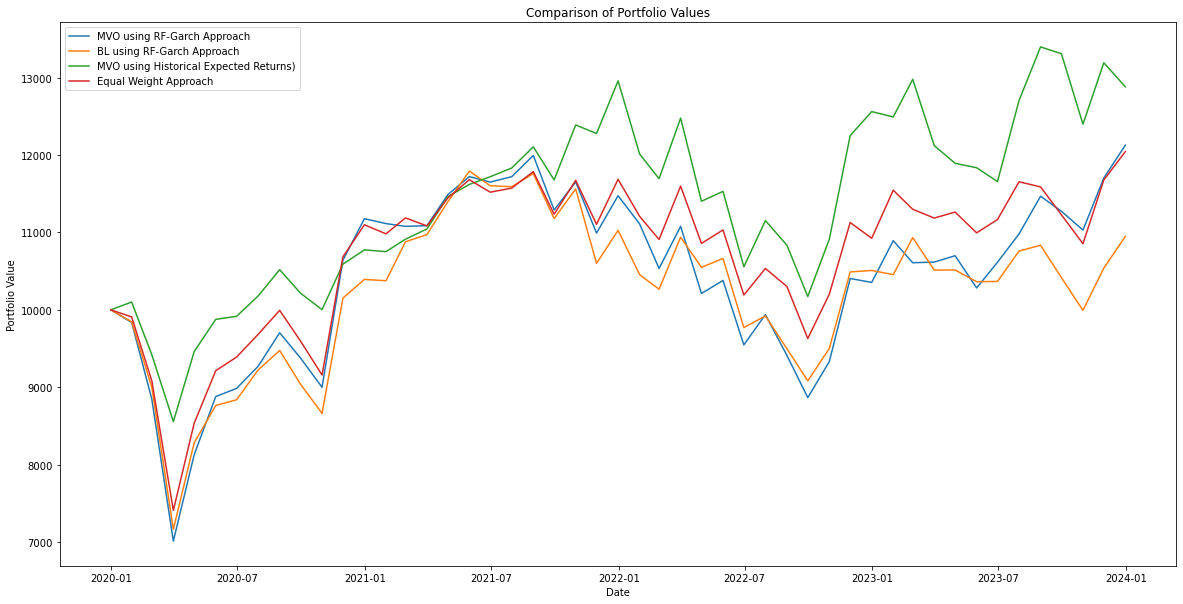

In [72]:

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Plotting the Portfolio Value from df1
plt.plot(df1['Portfolio_Value'], label='MVO using RF-Garch Approach')


plt.plot(df3['Portfolio_Value'], label='BL using RF-Garch Approach')

# Plotting the Portfolio Value from df2
plt.plot(df2['Portfolio_Value'], label='MVO using Historical Expected Returns)')

plt.plot(df4['Portfolio_Value'], label='Equal Weight Approach')
# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Comparison of Portfolio Values')
plt.legend()

# Display the plot
plt.show()

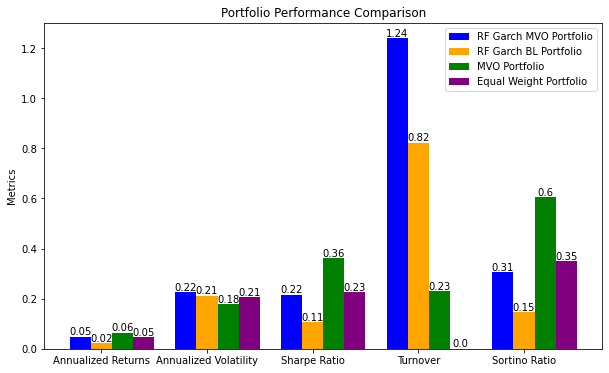

In [73]:
# data = {
#     'Metrics': ['', '', ''],
#     'Annualized Returns': [annualized_returns1, annualized_returns2, annualized_returns3],
#     'Annualized Volatility': [annualized_volatility1, annualized_volatility2, annualized_volatility3],
#     'Sharpe Ratio': [sharpe_ratio1, sharpe_ratio2, sharpe_ratio3]
# }

data = {
    'Metrics': ['Annualized Returns', 'Annualized Volatility', 'Sharpe Ratio','Turnover','Sortino Ratio'],
    'RF Garch MVO Portfolio': [annualized_returns1, annualized_volatility1, sharpe_ratio1,turnover1, sortino_ratio1],
    'RF Garch BL Portfolio': [annualized_returns3, annualized_volatility3, sharpe_ratio3,turnover3, sortino_ratio3],
    'MVO Portfolio': [annualized_returns2, annualized_volatility2, sharpe_ratio2,turnover2, sortino_ratio2],
    'Equal Weight Portfolio': [annualized_returns4, annualized_volatility4, sharpe_ratio4,turnover4, sortino_ratio4]
}

df = pd.DataFrame(data)

# Set the positions and width for the bars
positions = np.arange(len(df['Metrics']))
bar_width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each portfolio
for i, (portfolio, color) in enumerate(zip(df.columns[1:], ['blue', 'orange', 'green','purple'])):
    bars = ax.bar(positions + i * bar_width, df[portfolio], bar_width, label=portfolio, color=color)
    
    # Add number labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
ax.set_ylabel('Metrics')
ax.set_title('Portfolio Performance Comparison')
ax.set_xticks(positions + bar_width)
ax.set_xticklabels(df['Metrics'])
ax.legend()

# Show the plot
plt.show()

In [ ]:
pd.DataFrame(portfolio_performance_mvo)

,end_date,forecast_date,cleaned_weights
0,2020-01-01,2020-01-31,"{'AAPL': 0.17784, 'AMD': 0.44396, 'AMZN': 0.0,..."
1,2020-02-01,2020-02-29,"{'AAPL': 0.20221, 'AMD': 0.34224, 'AMZN': 0.0,..."
2,2020-03-01,2020-03-31,"{'AAPL': 0.18411, 'AMD': 0.39554, 'AMZN': 0.0,..."
3,2020-04-01,2020-04-30,"{'AAPL': 0.06316, 'AMD': 0.5, 'AMZN': 0.0, 'CS..."
4,2020-05-01,2020-05-31,"{'AAPL': 0.02509, 'AMD': 0.5, 'AMZN': 0.02511,..."
5,2020-06-01,2020-06-30,"{'AAPL': 0.03667, 'AMD': 0.5, 'AMZN': 0.0, 'CS..."
6,2020-07-01,2020-07-31,"{'AAPL': 0.13213, 'AMD': 0.34524, 'AMZN': 0.0,..."
7,2020-08-01,2020-08-31,"{'AAPL': 0.08201, 'AMD': 0.40167, 'AMZN': 0.0,..."
8,2020-09-01,2020-09-30,"{'AAPL': 0.21365, 'AMD': 0.31623, 'AMZN': 0.0,..."
9,2020-10-01,2020-10-31,"{'AAPL': 0.14197, 'AMD': 0.23262, 'AMZN': 0.0,..."


In [ ]:
pd.DataFrame(portfolio_performance)

,end_date,forecast_date,cleaned_weights
0,2020-01-01,2020-01-31,"{'AAPL': 0.0, 'GOOGL': 0.0, 'MSFT': 0.0, 'AMZN..."
1,2020-02-01,2020-02-29,"{'AAPL': 0.17215, 'GOOGL': 0.0, 'MSFT': 0.0, '..."
2,2020-03-01,2020-03-31,"{'AAPL': 0.0, 'GOOGL': 0.0, 'MSFT': 0.0, 'AMZN..."
3,2020-04-01,2020-04-30,"{'AAPL': 0.0, 'GOOGL': 0.26127, 'MSFT': 0.0, '..."
4,2020-05-01,2020-05-31,"{'AAPL': 0.0, 'GOOGL': 0.0, 'MSFT': 0.17525, '..."
5,2020-06-01,2020-06-30,"{'AAPL': 0.04593, 'GOOGL': 0.17207, 'MSFT': 0...."
6,2020-07-01,2020-07-31,"{'AAPL': 0.0, 'GOOGL': 0.18449, 'MSFT': 0.0, '..."
7,2020-08-01,2020-08-31,"{'AAPL': 0.0, 'GOOGL': 0.0, 'MSFT': 0.07754, '..."
8,2020-09-01,2020-09-30,"{'AAPL': 0.5, 'GOOGL': 0.0, 'MSFT': 0.16109, '..."
9,2020-10-01,2020-10-31,"{'AAPL': 0.0, 'GOOGL': 0.0, 'MSFT': 0.0, 'AMZN..."


In [ ]:
pd.DataFrame(portfolio_performance_bl).to_csv('example_portfolio.csv')

In [ ]:
df3.to_csv('portfolio_backtest_results.csv')